# Setup

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import scrnatools as rna
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import math
import phagepy
from phagepy import analysis
from scipy.stats import ttest_ind

In [3]:
# Setup figure params
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Helvetica"
sc.set_figure_params(dpi=80, dpi_save=300, facecolor="white", frameon=False)
sns.set_context("paper")
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.unicode_minus'] = False
cmap = sns.color_palette("colorblind")

In [4]:
warnings.resetwarnings()

# Method definitions

In [76]:
def average_tech_reps(adata, sample_key, layer="X"):
    counts = rna.tl.get_expression_matrix(adata, gene_data=layer)
    counts[sample_key] = adata.obs[sample_key]
    counts = counts.groupby(sample_key).mean()
    avg_adata = sc.AnnData(counts)
    obs = pd.DataFrame(adata.obs.copy())
    obs.index = obs[sample_key]
    obs = obs.drop_duplicates(subset=sample_key)
    avg_adata.obs = avg_adata.obs.join(obs)
    return avg_adata

def calculate_FC(adata, control_key, control_values, layer="X", layer_added="FC"):
    control_data = rna.tl.get_expression_matrix(
        adata[adata.obs[control_key].isin(control_values)],
        gene_data=layer
    )
    if np.any(np.sum(control_data,axis=0)==0):
        raise ValueError('Zero expression peptides. Pseudocount +1 before running.')
    all_data = rna.tl.get_expression_matrix(adata, gene_data=layer)
    adata.layers[layer_added] = all_data/control_data.mean()
    
def calculate_Z(adata, control_key, control_values, layer="X", layer_added="Z_score"):
    control_data = rna.tl.get_expression_matrix(
        adata[adata.obs[control_key].isin(control_values)],
        gene_data=layer
    )
    if sum(control_data.sum(axis=0) == 0) > 0:
        print("Warning: some peptides have 0 variance in the control samples, some Z scores will be inf/NA")
    mean = control_data.mean(axis=0)
    std = control_data.std(axis=0) # Uses unbiased estimator of population variance by default (div by n-1 instead of n)
    all_data = rna.tl.get_expression_matrix(adata, gene_data=layer)
    adata.layers[layer_added] = (all_data-mean)/std
    
def get_peptide_stats(adata, FC_layer, Z_layer, FC_thresh, Z_thresh, obs_grouping_key, key_added="hits", stats_layer=None):
    FC_thresholded = rna.tl.get_expression_matrix(adata, gene_data=FC_layer) > FC_thresh
    Z_thresholded = rna.tl.get_expression_matrix(adata, gene_data=Z_layer) > Z_thresh
    hits = FC_thresholded & Z_thresholded
    
    hits[obs_grouping_key] = adata.obs[obs_grouping_key]
    hits = hits.groupby(obs_grouping_key).sum().T
    hits["gene"] = adata.var.gene
    hits["gene_isoform"] = adata.var.gene_isoform
    hits["sequence"] = adata.var.sequence
    
    if stats_layer is None:
        stats_layer = FC_layer
    LFC_background = rna.tl.get_expression_matrix(adata, gene_data=stats_layer)
    LFC_background[obs_grouping_key] = adata.obs[obs_grouping_key]
    group_min = LFC_background.groupby(obs_grouping_key).min().T
    hits = hits.join(group_min, rsuffix='_min')
    group_max = LFC_background.groupby(obs_grouping_key).max().T
    hits = hits.join(group_max, rsuffix='_max')
    group_med = LFC_background.groupby(obs_grouping_key).median().T
    hits = hits.join(group_med, rsuffix='_median')
    group_mean = LFC_background.groupby(obs_grouping_key).mean().T
    hits = hits.join(group_mean, rsuffix='_mean')
    
    adata.varm[f"{key_added}_peptide"] = hits
    
    gene_LFC_data = rna.tl.get_expression_matrix(averaged_adata, gene_data=stats_layer).T
    gene_LFC_data["gene"] = averaged_adata.var.gene
    gene_LFC_data = gene_LFC_data.groupby("gene").sum().T
    gene_hits = pd.DataFrame(index=gene_LFC_data.columns)
    gene_LFC_data[obs_grouping_key] = averaged_adata.obs[obs_grouping_key]

    group_min = gene_LFC_data.groupby(obs_grouping_key).min().T
    group_min.columns = [i + "_min" for i in group_min.columns]
    gene_hits = gene_hits.join(group_min)
    group_max = gene_LFC_data.groupby(obs_grouping_key).max().T
    group_max.columns = [i + "_max" for i in group_max.columns]
    gene_hits = gene_hits.join(group_max)
    group_med = gene_LFC_data.groupby(obs_grouping_key).median().T
    group_med.columns = [i + "_median" for i in group_med.columns]
    gene_hits = gene_hits.join(group_med)
    group_mean = gene_LFC_data.groupby(obs_grouping_key).mean().T
    group_mean.columns = [i + "_mean" for i in group_mean.columns]
    gene_hits = gene_hits.join(group_mean)
    
    adata.uns[f"{key_added}_gene"] = gene_hits
    

def corr_plot(adata, layer="X", labels=None, cbar_args = [1, 0.25, 0.01, 0.5], save_path=None, *args, **kwargs):
    data = rna.tl.get_expression_matrix(adata, gene_data=layer)
    gene_corrs = pd.DataFrame(np.corrcoef(data), index=data.index, columns=data.index)
    if labels is not None:
        label_names = adata.obs.loc[gene_corrs.index, labels]
        gene_corrs.index = label_names
        gene_corrs.columns = label_names
    cg = sns.clustermap(
        gene_corrs,
        cmap="coolwarm",
        yticklabels=True,
        xticklabels=True,
        *args, **kwargs
    )

    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_heatmap.set_ylabel("")
    cg.ax_heatmap.set_xlabel("")
    cg.ax_cbar.set_position(cbar_args)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    
def plot_FC_sum(adata, FC_layer, obs_group_key, obs_group_values=None, ylim=None, save_path=None, *args, **kwargs):
    FC_data = rna.tl.get_expression_matrix(adata, gene_data=FC_layer)
    FC_data[FC_data < 0] = 0
    FC_data = pd.DataFrame(FC_data.sum(axis=1))
    FC_data[obs_group_key] = averaged_adata.obs[obs_group_key]
    
    if obs_group_values is not None:
        FC_data = FC_data[FC_data[obs_group_key].isin(obs_group_values)]
        
    plt.figure(figsize=(3,4))
    ax=sns.boxplot(
        FC_data,
        x=obs_group_key,
        y=0,
        *args, **kwargs
    )
    plt.xticks(rotation=90)
    plt.ylabel("sum(LFC over background)")
    plt.xlabel("")
    if ylim is not None:
        ax.set_ylim(ylim)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    return FC_data

def gene_level_box_plot(adata, obs_key, layer, gene, isoform_subset = None, figsize=None, save_path=None, threshold=None, *args, **kwargs):
    #get peptide counts for WT and KO groups for a gene
    adata_gene = adata[:,adata.var.gene == gene]
    data = rna.tl.get_expression_matrix(adata_gene, gene_data=layer)
    if isoform_subset is not None:
        isoform_peptides = data.columns[data.columns.str.contains(isoform_subset)]
        data = data[isoform_peptides]
        data.columns = [i.split("]_seq")[1] for i in data.columns]
        x="variable"
    else:
        x="peptide"
    n_peptides = len(data.columns)
    data = data.melt()
    data[obs_key] = adata_gene.obs[obs_key].tolist()*n_peptides
    if figsize is None:
        figsize = n_peptides*0.5,5
    plt.figure(figsize = figsize)
    ax1 = sns.boxplot(
        data = data,
        x = x,
        y = "value",
        hue = obs_key,
        showfliers=False,
        *args, **kwargs
    )
    ax2 = sns.stripplot(
        data = data,
        x = x,
        y = "value",
        hue = obs_key,
        dodge=True,
        legend=False,
        linewidth = 1,
        s=3,
        *args, **kwargs
    )
    if threshold is not None:
        plt.axhline(y=threshold, c="black", linestyle="--")
    plt.xticks(rotation=90)
    plt.title(f"{gene}_{isoform_subset}")
    plt.xlabel("peptide")
    plt.ylabel(layer)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()
    
def peptide_level_box_plot(adata, obs_key, layer, peptide, figsize=(4,4), threshold=None, *args, **kwargs):
    adata_gene = adata[:,adata.var_names == peptide]
    data = rna.tl.get_expression_matrix(adata_gene, gene_data=layer)
    data.columns = [i.split("seq")[1] for i in data.columns]
    data = data.melt()
    data[obs_key] = adata_gene.obs[obs_key].tolist()
    plt.figure(figsize = figsize)
    ax1 = sns.boxplot(
        data = data,
        x = "variable",
        y = "value",
        hue = obs_key,
        showfliers=False,
        *args, **kwargs
    )
    ax2 = sns.stripplot(
        data = data,
        x = "variable",
        y = "value",
        hue = obs_key,
        dodge=True,
        legend=False,
        linewidth = 1,
        s=3,
        *args, **kwargs
    )
    if threshold is not None:
        plt.axhline(y=threshold, c="black", linestyle="--")
    plt.title(adata_gene.var["gene"][0])
    plt.xlabel(peptide)
    plt.ylabel(layer)
    plt.show()
    
def gene_LFC_sum_plot(
    adata, gene, LFC_layer, obs_grouping_key,
    isoform_subset=None,
    include_groups=None,
    figsize=(3,5),
    *args, **kwargs
):
    FC_data = rna.tl.get_expression_matrix(adata, LFC_layer).T
    if isoform_subset is not None:
        FC_data["gene"] = adata.var.gene_isoform
        gene = f"{gene}_{isoform_subset}"
    else:
        FC_data["gene"] = adata.var.gene
    FC_data = FC_data.groupby("gene").sum().T
    FC_data[obs_grouping_key] = adata.obs[obs_grouping_key]
    if include_groups is not None:
        FC_data = FC_data[FC_data[obs_grouping_key].isin(include_groups)]
    plt.figure(figsize=figsize)
    sns.boxplot(
        FC_data,
        x=obs_grouping_key,
        y=gene,
        *args, **kwargs
    )
    plt.title(gene)
    plt.xticks(rotation=90)
    plt.ylabel("sum(LFC over background)")
    plt.show()
    
def median_LFC_Z_score_plot(adata, Z_layer, LFC_layer, LFC_thresh, obs_grouping_key, obs_grouping_subset, hits, subset_nonzero=True, *args, **kwargs):
    LZ_score_data = rna.tl.get_expression_matrix(adata, gene_data=Z_layer)
    LZ_score_data[obs_grouping_key] = adata.obs[obs_grouping_key]
    LZ_score_data = LZ_score_data.groupby(obs_grouping_key).median().T
    LFC_data = rna.tl.get_expression_matrix(adata, gene_data=LFC_layer)
    LFC_data[obs_grouping_key] = adata.obs[obs_grouping_key]
    LFC_data = LFC_data.groupby(obs_grouping_key).median().T

    plot_data = pd.DataFrame({"LFC": LFC_data[obs_grouping_subset], "LZ": LZ_score_data[obs_grouping_subset]})
    plot_data["hit"] = [i in hits for i in plot_data.index]
    if subset_nonzero:
        plot_data = plot_data[plot_data.LFC > 0]
        plot_data = plot_data[plot_data.LZ > 0]
    sns.scatterplot(
        plot_data,
        x="LFC",
        y="LZ",
        hue="hit",
        linewidth=0,
        s=5
    )
    plt.axvline(x=np.log2(LFC_thresh), color="black")
    plt.show()
    
def LFC_heatmap(data, grouping=None, cell_width=30, cell_height=30, save_path=None, grouping_axis=0, *args, **kwargs):
    figdpi = plt.rcParams['figure.dpi']
    totalWidth = plt.rcParams['figure.subplot.right'] - plt.rcParams['figure.subplot.left']
    totalHeight = plt.rcParams['figure.subplot.top'] - plt.rcParams['figure.subplot.bottom']
    nrows, ncols = data.shape
    figWidth = (ncols*cell_width/figdpi)/totalWidth
    figHeight = (nrows*cell_height/figdpi)/totalHeight
    
    cg = sns.clustermap(
        data,
        figsize=(figWidth, figHeight),
        *args, **kwargs
    )

    axWidth = (ncols*cell_width)/(figWidth*figdpi)
    axHeight = (nrows*cell_height)/(figHeight*figdpi)
    ax_heatmap_og_pos = cg.ax_heatmap.get_position()
    cg.ax_heatmap.set_position(
        [ax_heatmap_og_pos.x0, ax_heatmap_og_pos.y0, axWidth, axHeight]
    )
    if grouping is not None:
        if grouping_axis == 0:
            cg.ax_heatmap.hlines(grouping, *cg.ax_heatmap.get_xlim(), color="black")
        if grouping_axis == 1:
            cg.ax_heatmap.vlines(grouping, *cg.ax_heatmap.get_ylim(), color="black")
    cbar_x_pos = 0.85 + ax_heatmap_og_pos.x0
    cbar_y_pos = ax_heatmap_og_pos.y0
    cbar_width = 25/(figWidth*300)
    cbar_height = axHeight
    cbar_args = [cbar_x_pos, cbar_y_pos, cbar_width, cbar_height]
    cg.ax_cbar.set_position(cbar_args)
    cg.ax_cbar.grid(False)
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    cg.ax_heatmap.yaxis.tick_left()
    cg.ax_heatmap.set_ylabel("")
    cg.ax_heatmap.set_xlabel("")
    cg.ax_heatmap.grid(False)
    cg.ax_heatmap.tick_params(axis='y', labelrotation=0)
    cg.ax_heatmap.tick_params(axis='x', labelrotation=90)
    cg.ax_heatmap.tick_params(bottom=True, left=True)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()

# Import data

In [6]:
rawDataPath = "/mnt/iacchus/joe/raw_data/"
processedDataPath = "/mnt/iacchus/joe/processed_data/"

In [7]:
peptide_data = pd.read_csv(f"{rawDataPath}Thymus/Fezf2_Phip_seq/rpk_peptide.csv", index_col=0).T
metadata = pd.read_csv(f"{rawDataPath}Thymus/Fezf2_Phip_seq/metadata.csv", index_col=0).dropna(axis=0)

peptide_data.index = peptide_data.index.str.replace('resubmission_Feb_09_2024_', 'Jan_16_2024_')
peptide_data = peptide_data[peptide_data.index.isin(metadata.index)]

## make AnnData/cleanup metadata

In [8]:
adata=sc.AnnData(X=peptide_data, dtype=np.float32)
adata.raw = adata
adata.obs = adata.obs.join(metadata)
# adata.obs.genotype.value_counts()

/home/joe/anaconda3/envs/fezf2-thymus-env/lib/python3.9/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


In [85]:
adata.obs.Genotype = adata.obs.Genotype.replace({"Fezf2 WT": "Fezf2WT"})
adata.obs["Condition"] = adata.obs.Genotype + "-" + adata.obs.Strain
adata = adata[
    adata.obs.Condition.str.contains("Fezf2") |
    adata.obs.Condition.str.contains("Rag2") |
    adata.obs.Condition.str.contains("GFAP")
]

In [86]:
adata.obs.Condition.value_counts()

Rag2(KO)-B6      20
Fezf2WT-B6       16
Fezf2KO-B6       14
Fezf2 Enr-CD1    14
Fezf2KO-CD1      12
Fezf2WT-CD1       8
GFAP-GFAP         4
Name: Condition, dtype: int64

In [11]:
adata.obs["SAMPLE_NAME"] = adata.obs.Genotype + "-" + adata.obs.Strain + "-" + adata.obs["Biological Replicate"].astype(str)
adata.obs_names = [i.rsplit("_", 11)[0] for i in adata.obs_names]
adata.obs_names_make_unique()

# Technical replicate processing

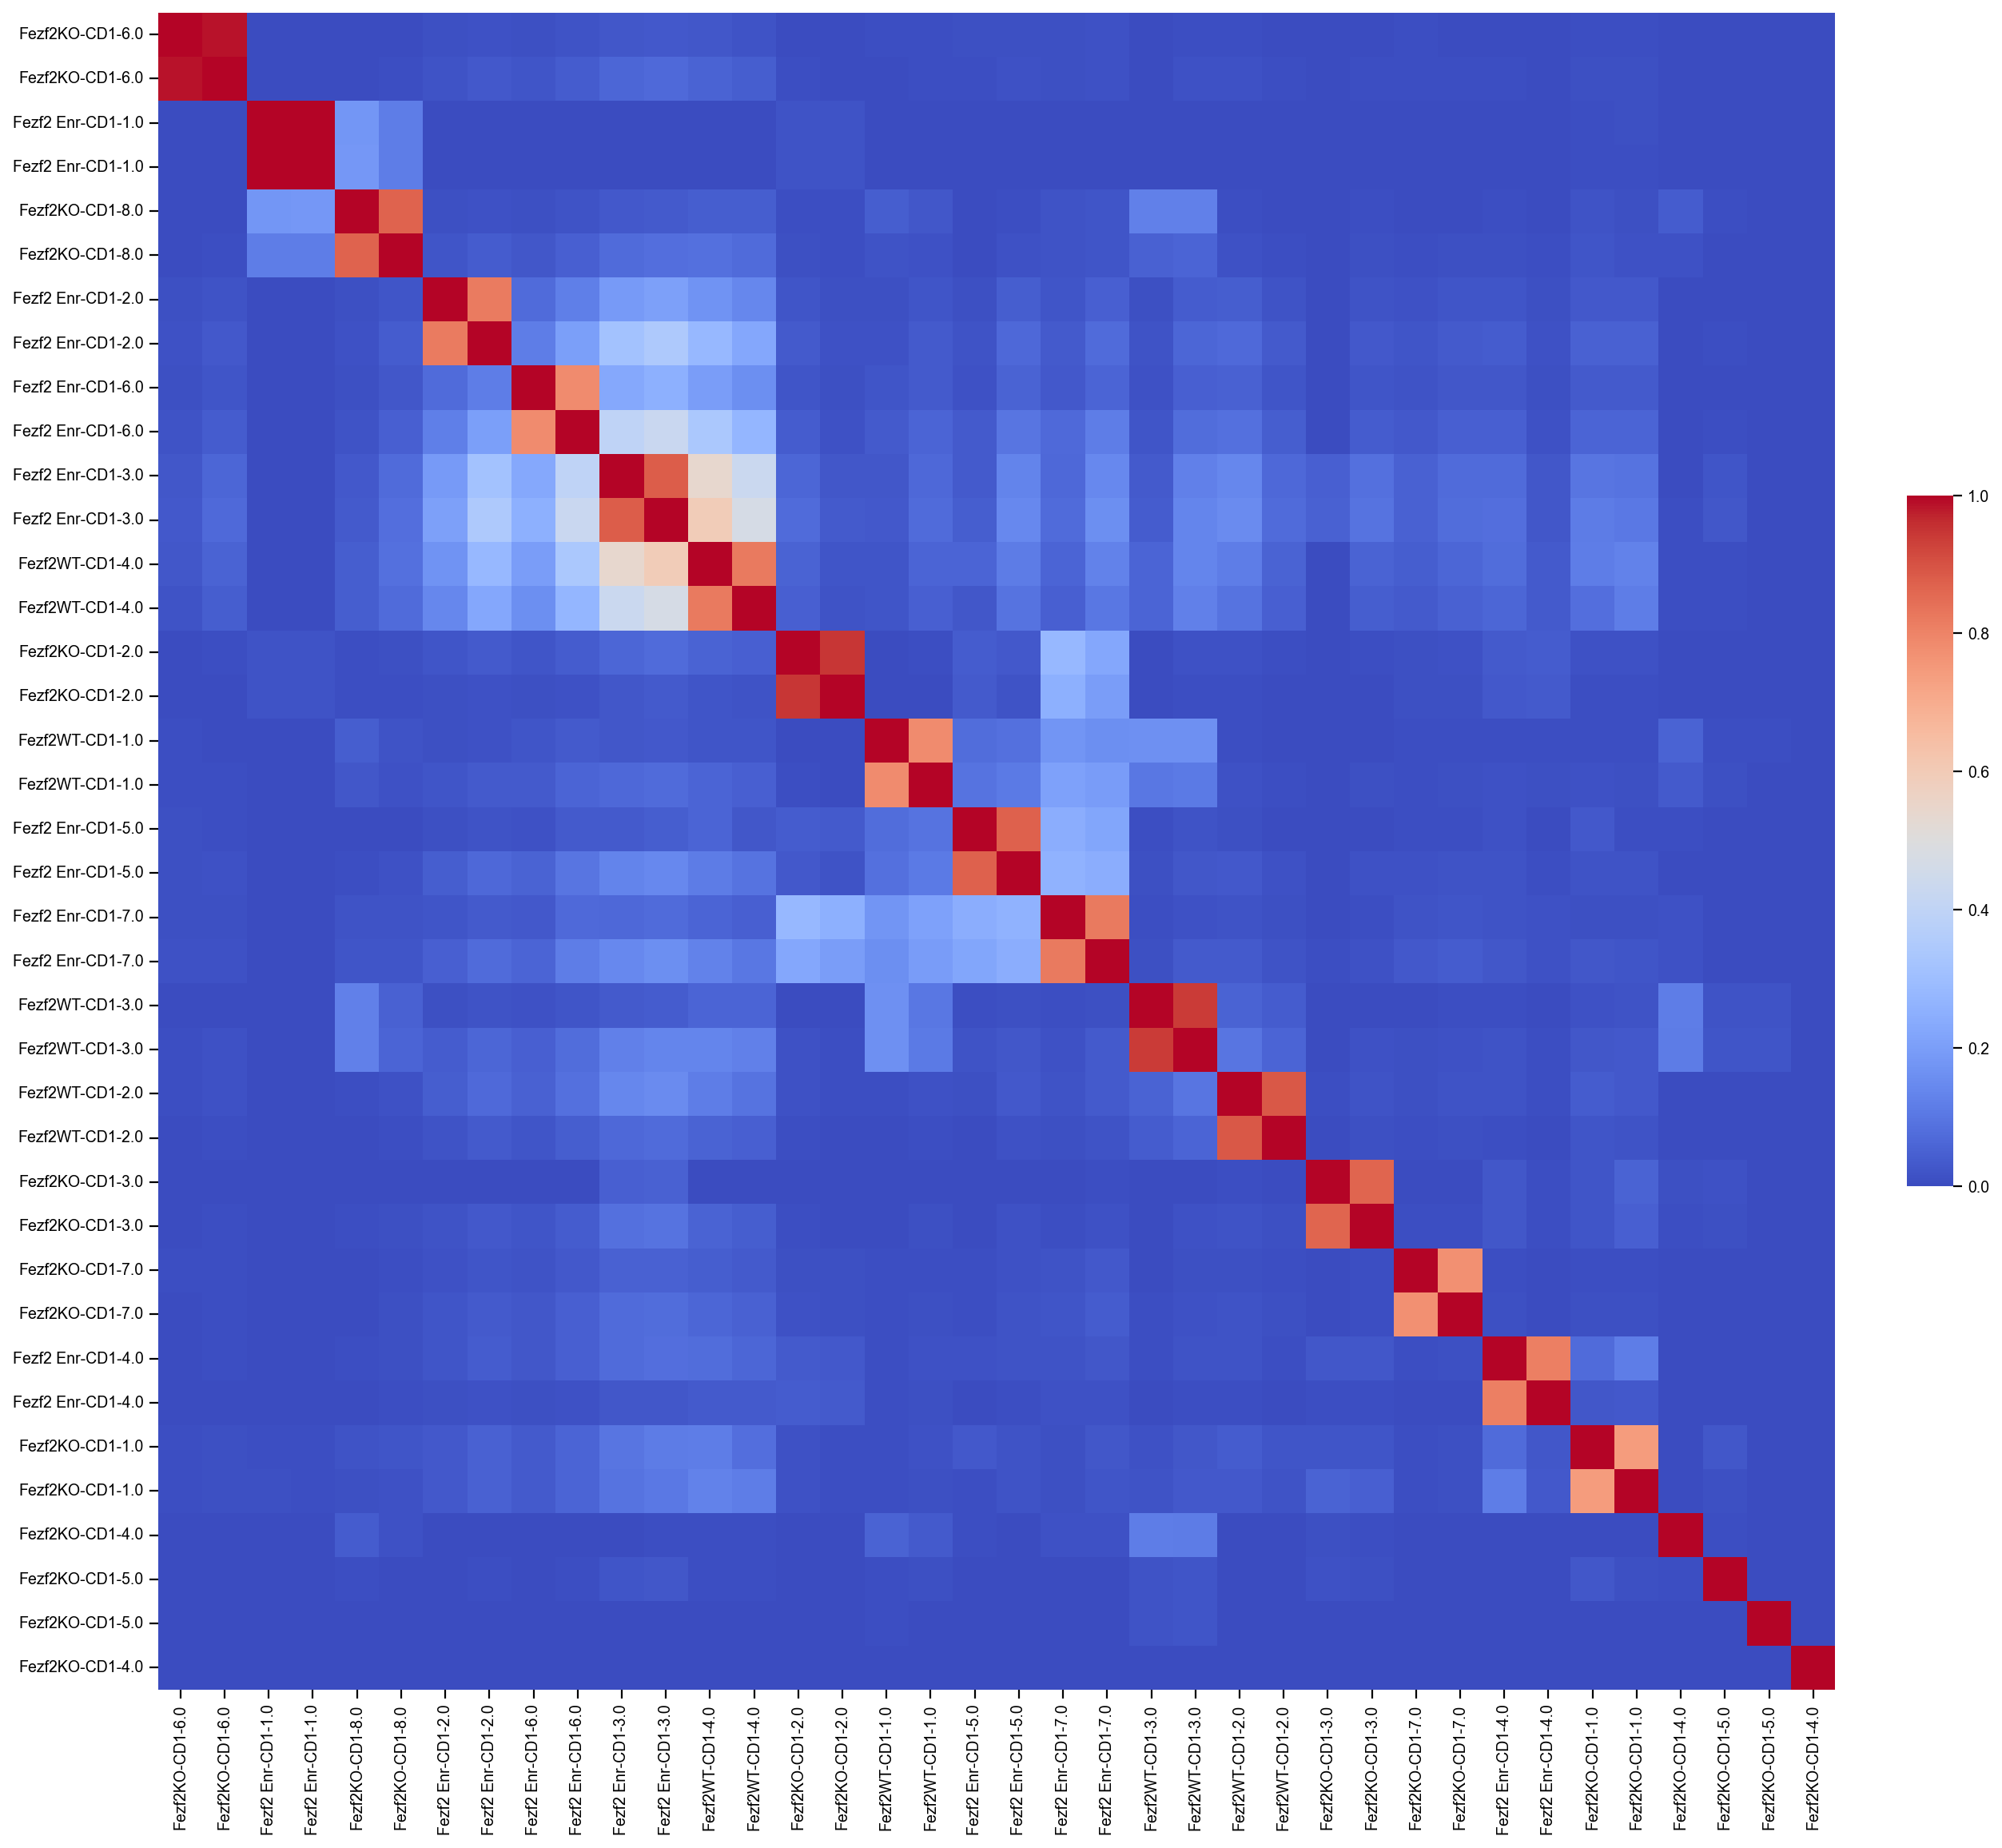

In [12]:
corr_plot(
    adata[adata.obs.Condition.isin(["Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"])],
    figsize=(18,18),
    layer="X",
    labels="SAMPLE_NAME",
    cbar_args=[0.95, 0.3, 0.02, 0.3],
    vmin=0,
)

## Remove failed replicates

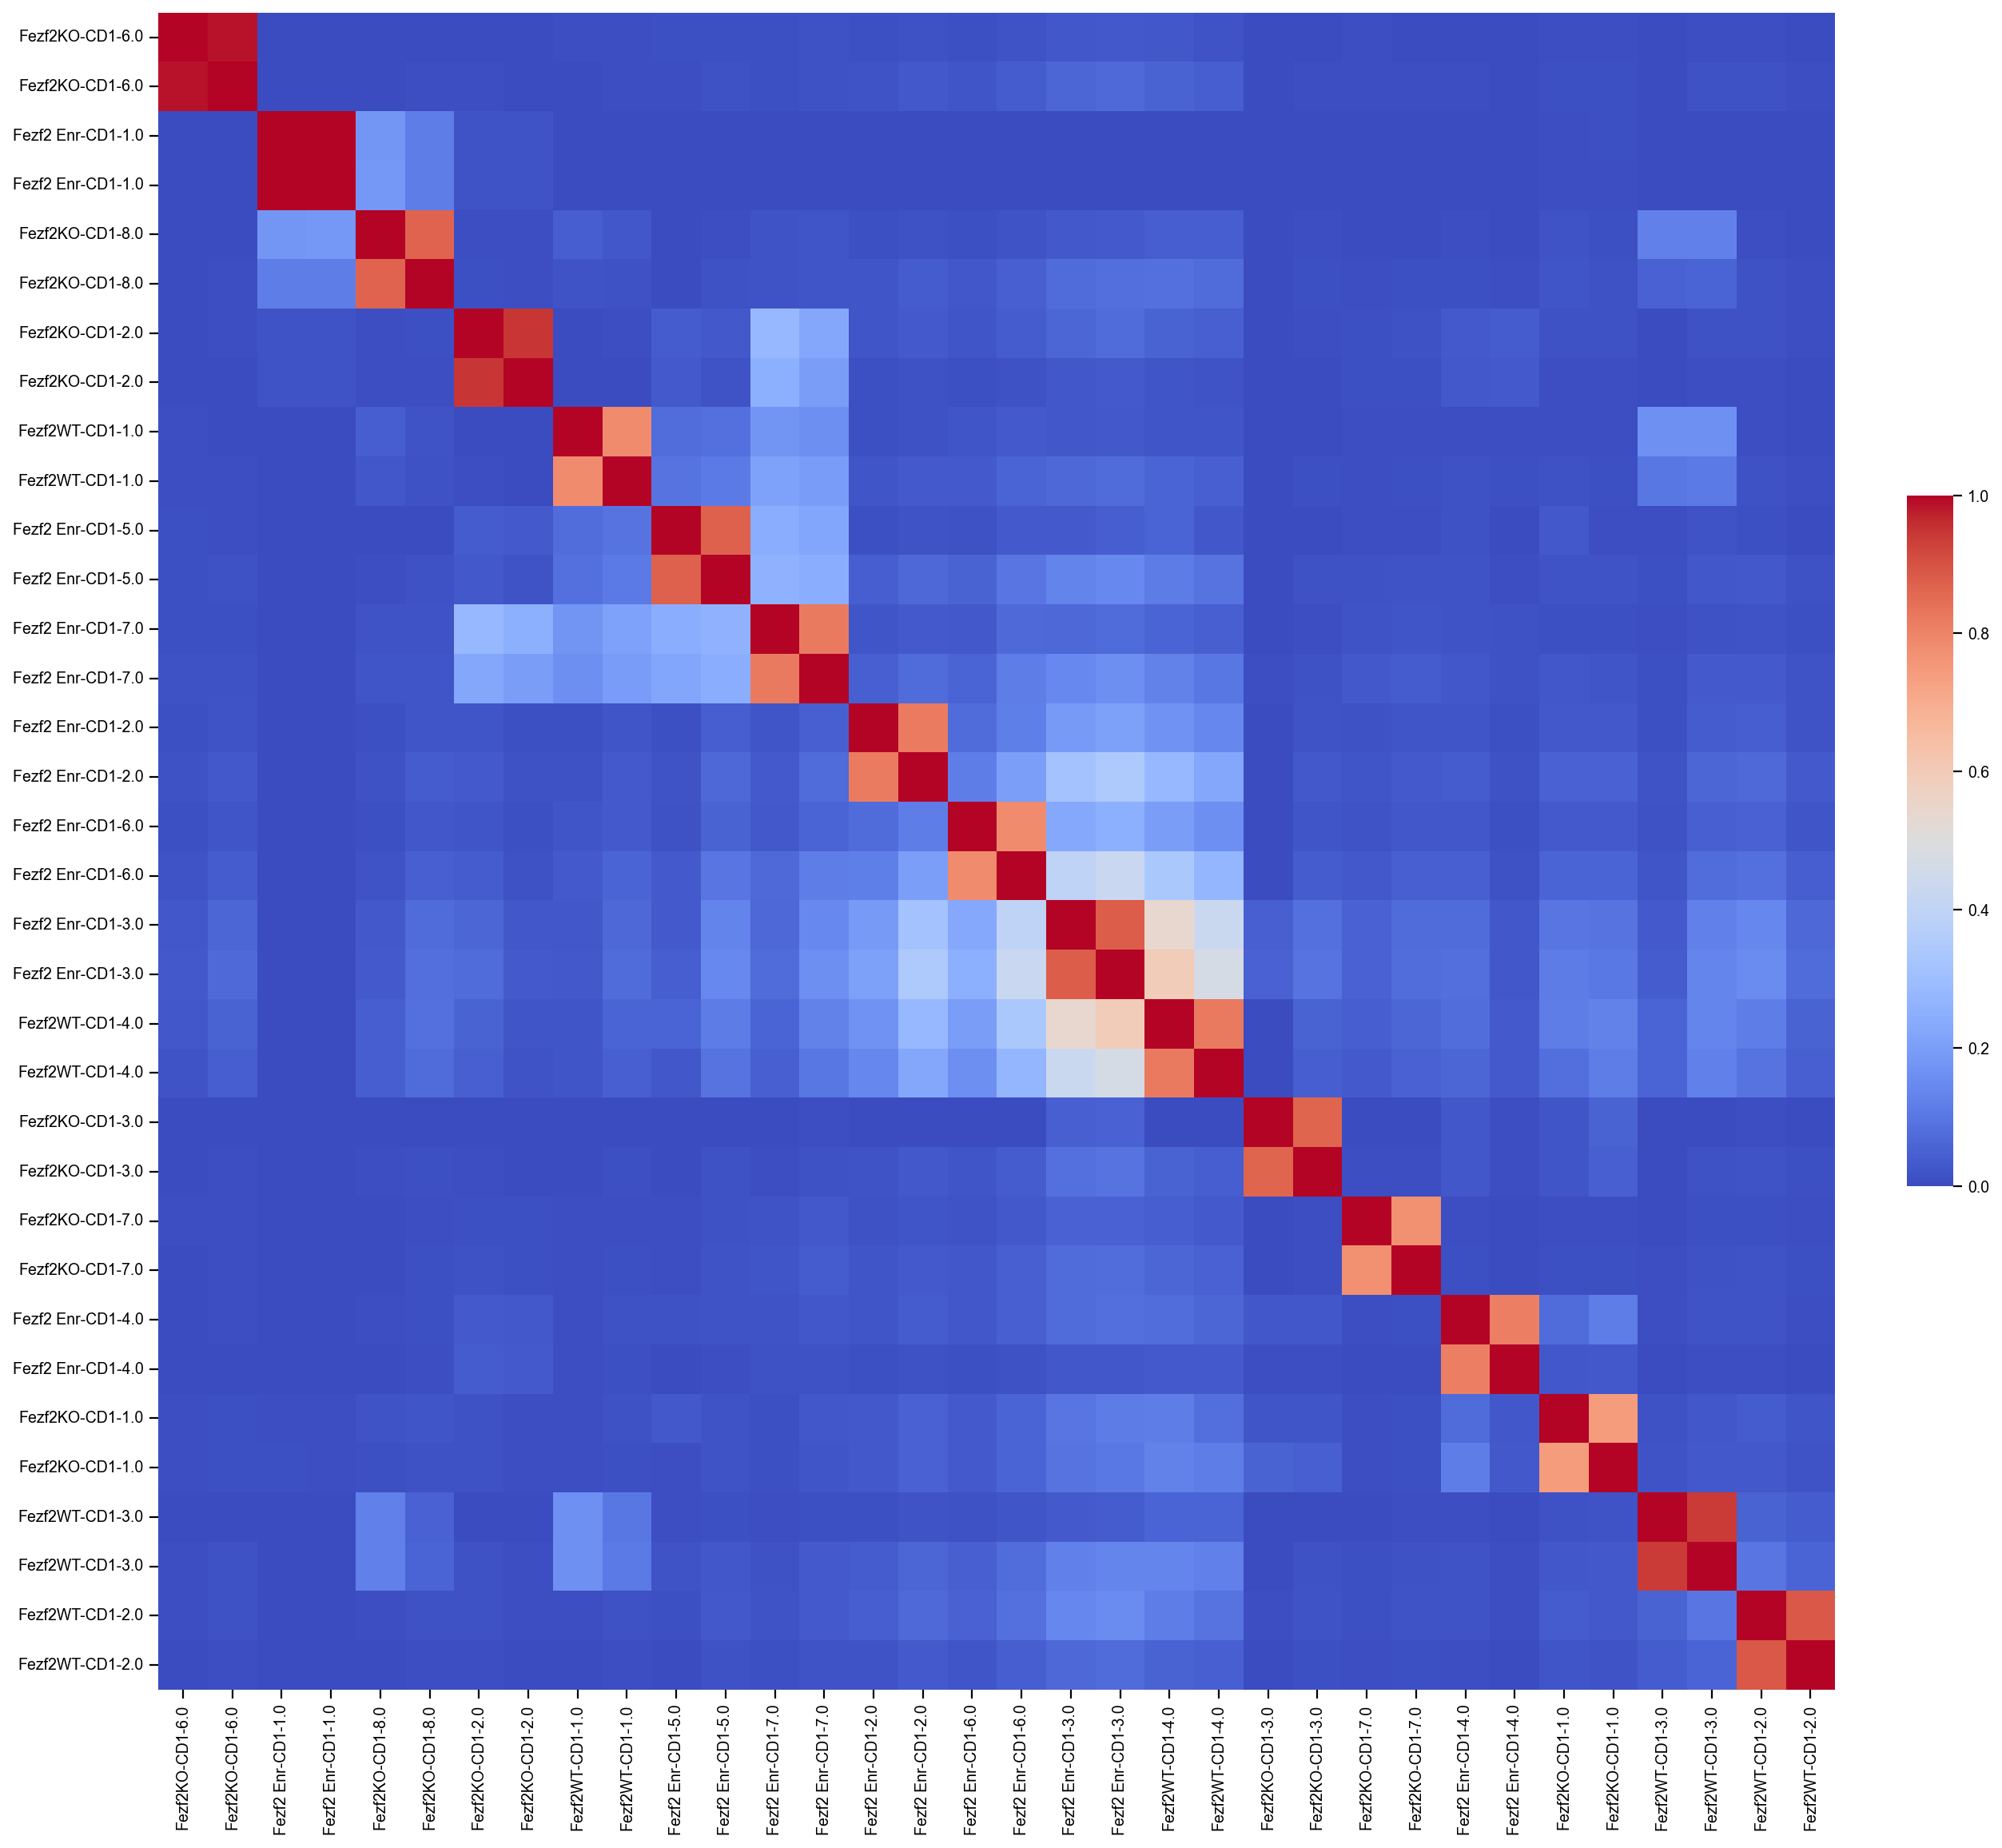

In [61]:
adata = adata[~adata.obs.SAMPLE_NAME.isin(["Fezf2KO-CD1-5.0", "Fezf2KO-CD1-4.0"])]
corr_plot(
    adata[adata.obs.Condition.isin(["Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"])],
    figsize=(18,18),
    layer="X",
    labels="SAMPLE_NAME",
    cbar_args=[0.95, 0.3, 0.02, 0.3],
    vmin=0,
    save_path="../analysis/paper_figures/S7/S7D_PhIP_seq_correlation.pdf"
)

In [14]:
#Take average counts of technical replicates
averaged_adata = average_tech_reps(
    adata = adata,
    sample_key = "SAMPLE_NAME"
)

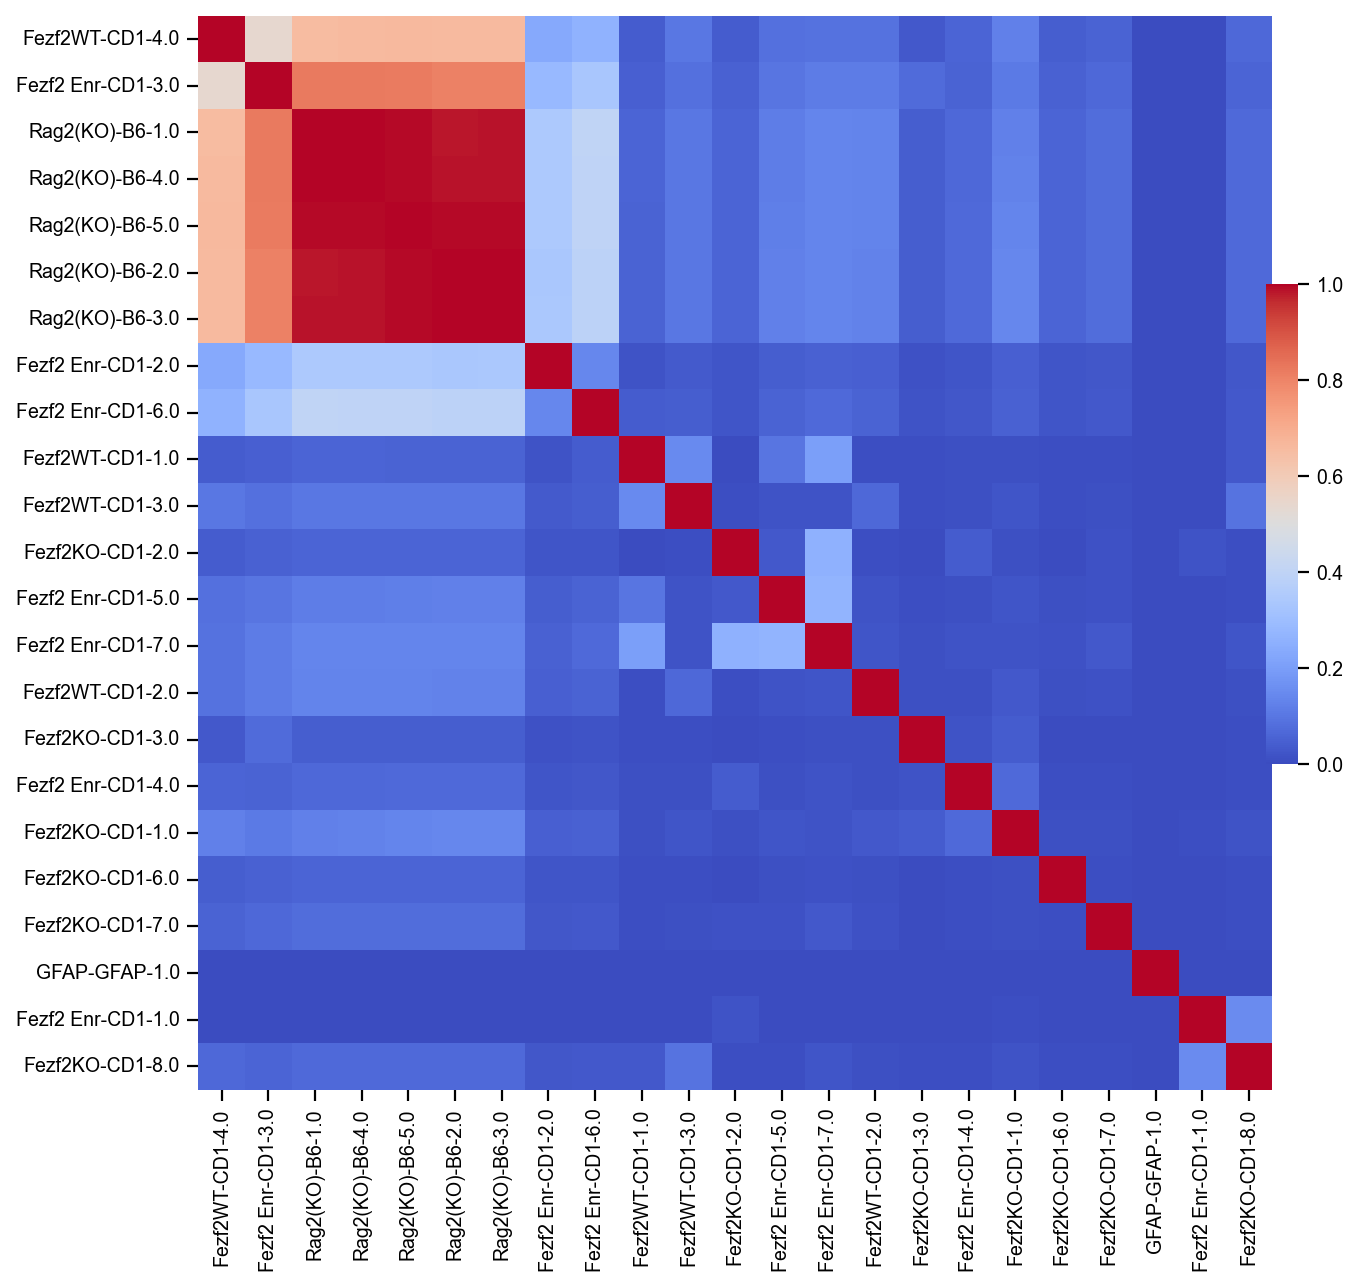

In [15]:
corr_plot(
    averaged_adata[averaged_adata.obs.Condition.isin(["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1", "GFAP-GFAP"])],
    layer="X",
    figsize=(10,10),
    labels="SAMPLE_NAME",
    vmin=0,
    cbar_args=[0.85, 0.35, 0.02, 0.3],
    # save_path="../analysis/B6_phip_seq/biological_replicate_coorelation.pdf"
)

## Add metadata columns to obs/var for analysis

In [16]:
#This file is publically available and can be accessed through https://www.protocols.io/workspaces/derisi-lab
new_annot = pd.read_csv(f"{rawDataPath}Thymus/Fezf2_Phip_seq/gene_annotations.csv", index_col=0)
averaged_adata.var["gene"] = new_annot.gene
averaged_adata.var["sequence"] = new_annot.sequence
averaged_adata.var["isoform"] = [f"isoform_{i.split('isoform')[1].split('_')[1]}" if "isoform" in i else "" for i in averaged_adata.var_names]
averaged_adata.var["gene_isoform"] = averaged_adata.var.gene + "_" + averaged_adata.var.isoform
averaged_adata.obs["neg_control"] = ["Background" if i in ["Rag2(KO)-B6"] else i for i in averaged_adata.obs.Condition]

# Normalize to background

In [17]:
# Pseudocount data for LFC calculation
averaged_adata.layers["rpk+1"] = averaged_adata.X + 1

In [18]:
calculate_FC(
    averaged_adata,
    control_key='neg_control',
    control_values=["Background"],
    layer='rpk+1',
    layer_added="FC_background"
)
averaged_adata.layers["LFC_background"] = np.log2(averaged_adata.layers["FC_background"])

# Z score

In [20]:
calculate_Z(
    averaged_adata,
    control_key='neg_control',
    control_values=["Background"],
    layer='LFC_background',
    layer_added="Z_score_background"
)
averaged_adata.layers["LZ_score_background"] = np.log2(averaged_adata.layers["Z_score_background"])

/tmp/ipykernel_1122030/824801542.py:8: RuntimeWarning: invalid value encountered in log2
  averaged_adata.layers["LZ_score_background"] = np.log2(averaged_adata.layers["Z_score_background"])


averaged_adata# Get peptide hits

In [21]:
averaged_adata.obs.neg_control.value_counts()

Aire(KO)-NOD     24
Aire(WT)-NOD     17
Fezf2WT-B6        8
Fezf2 Enr-CD1     7
Fezf2KO-B6        7
Fezf2KO-CD1       6
Aire(KO)-B6       5
Background        5
Fezf2WT-CD1       4
GFAP-GFAP         1
Name: neg_control, dtype: int64

# Compute hits stats

In [22]:
get_peptide_stats(
    averaged_adata,
    FC_layer = "LFC_background",
    FC_thresh = np.log2(3),
    Z_layer = "Z_score_background",
    Z_thresh = 3,
    obs_grouping_key="neg_control"
)

In [23]:
hits = averaged_adata.varm['hits_peptide'].copy()
gene_hits = averaged_adata.uns['hits_gene'].copy()

# Get hits

## Fezf2 KO B6

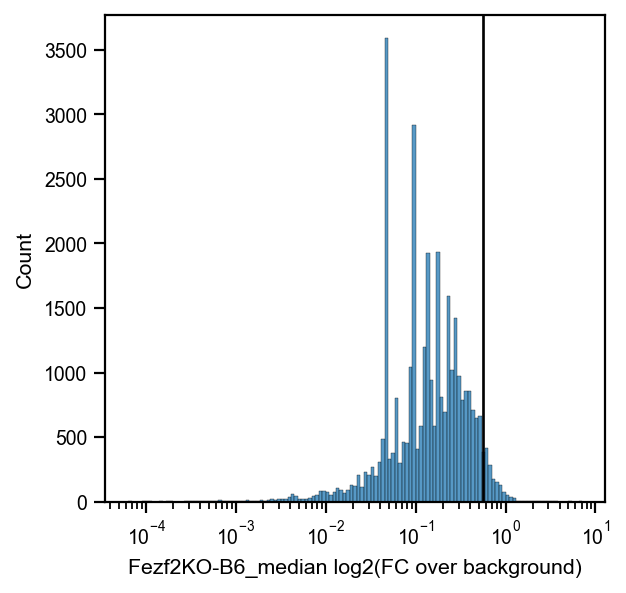

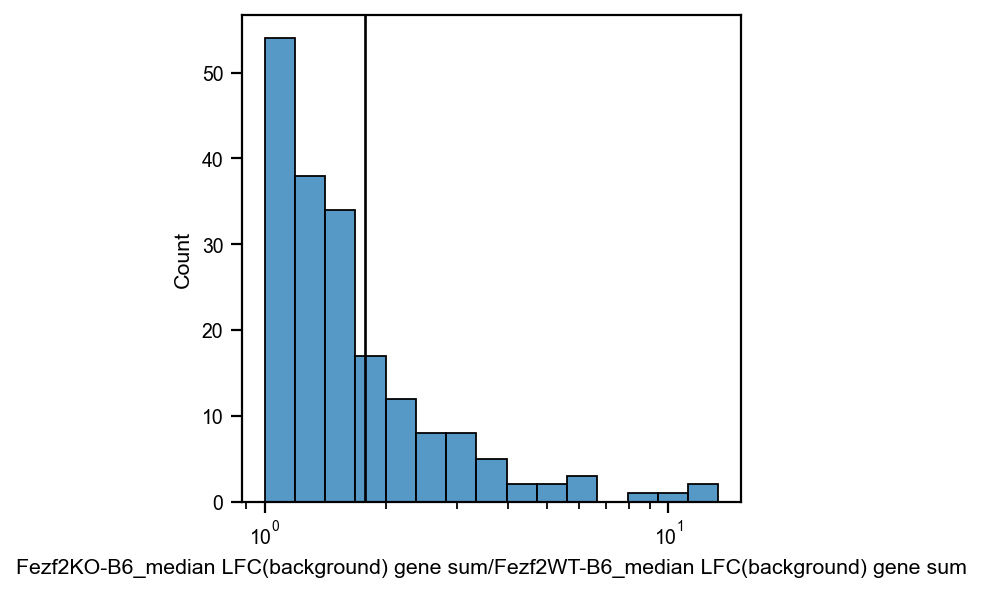

neg_control,Aire(KO)-B6,Aire(KO)-NOD,Aire(WT)-NOD,Background,Fezf2 Enr-CD1,Fezf2KO-B6,Fezf2KO-CD1,Fezf2WT-B6,Fezf2WT-CD1,GFAP-GFAP,...,Aire(KO)-NOD_mean,Aire(WT)-NOD_mean,Background_mean,Fezf2 Enr-CD1_mean,Fezf2KO-B6_mean,Fezf2KO-CD1_mean,Fezf2WT-B6_mean,Fezf2WT-CD1_mean,GFAP-GFAP_mean,gene_FC
peptide,,,,,,,,,,,,,,,,,,,,,
NP_079631.2_transcription_elongation_factor_A_(SII)-like_6_[Mus_musculus]_seq2,0,1,0,0,0,0,1,0,0,0,...,0.279555,0.244006,0.025061,0.081919,0.585196,0.465353,0.065496,0.000000,1.573639,4.113142
XP_017171748.1_PREDICTED:_uncharacterized_protein_LOC108168152_isoform_X3_[Mus_musculus]_seq1,0,0,1,0,0,1,0,0,0,0,...,0.326413,0.376071,0.000000,0.118409,0.794917,0.068896,0.146417,0.311876,0.141050,1.850232
XP_006538025.1_PREDICTED:_thiosulfate_sulfurtransferase/rhodanese-like_domain-containing_protein_2_isoform_X1_[Mus_musculus]_seq7,0,0,0,0,0,0,0,0,0,0,...,0.203143,0.358299,0.003921,0.031916,0.615507,0.118773,0.169898,0.120491,0.722087,2.798755
NP_001280615.1_vesicle_transport_through_interaction_with_t-SNAREs_homolog_1A_isoform_3_[Mus_musculus]_seq2,0,4,0,0,0,0,0,0,0,0,...,0.994213,0.157524,0.297032,0.137578,0.525230,0.164938,0.010180,0.187795,1.719863,3.477491
XP_017171905.1_PREDICTED:_voltage-dependent_L-type_calcium_channel_subunit_beta-3_isoform_X6_[Mus_musculus]_seq4,0,0,0,0,0,2,0,0,1,0,...,0.050111,0.086460,0.153909,0.335904,1.854463,0.081200,0.076364,0.540669,0.120289,2.452374
XP_006530380.1_PREDICTED:_protein_strawberry_notch_homolog_1_isoform_X1_[Mus_musculus]_seq20,0,0,0,0,1,0,0,0,0,0,...,0.065746,0.094741,0.000000,0.398425,0.585925,0.032979,0.029472,0.188515,0.608772,2.518003
NP_789806.1_protein_FAM76B_[Mus_musculus]_seq7,0,0,0,0,1,0,0,0,0,0,...,0.109599,0.080853,0.096613,0.799683,0.674772,0.210267,0.058809,0.000000,0.076828,1.945643
XP_006521117.1_PREDICTED:_zinc_finger_protein_385A_isoform_X2_[Mus_musculus]_seq5,0,0,0,0,0,0,0,0,1,0,...,0.106213,0.029937,0.181220,0.000000,0.450265,0.298650,0.000000,0.618071,0.000000,2.134568
XP_017172308.1_PREDICTED:_spermatid_perinuclear_RNA-binding_protein_isoform_X1_[Mus_musculus]_seq1,0,0,0,0,0,1,0,0,1,0,...,0.065727,0.052364,0.168206,0.111317,0.785186,0.000000,0.078565,0.474515,0.000000,2.344967


In [36]:
genotype_stat = "Fezf2KO-B6_median"
control_genotype_stat = "Fezf2WT-B6_max"
hits_Fezf2_KO_B6 = hits[hits[genotype_stat] > 0].copy() # Get rid of peptides with LFC over background <= 0

background_thresh = np.quantile(hits_Fezf2_KO_B6[genotype_stat], 0.95)
sns.histplot(hits_Fezf2_KO_B6[genotype_stat], log_scale=True)
plt.axvline(x=background_thresh, c="black")
plt.xlabel(f"{genotype_stat} log2(FC over background)")
plt.show()

hits_Fezf2_KO_B6 = hits_Fezf2_KO_B6[hits_Fezf2_KO_B6[genotype_stat] >= background_thresh].copy()
hits_Fezf2_KO_B6 = hits_Fezf2_KO_B6[hits_Fezf2_KO_B6[control_genotype_stat] < background_thresh]
hits_Fezf2_KO_B6["gene_FC"] = list(gene_hits.loc[hits_Fezf2_KO_B6.gene, "Fezf2KO-B6_median"]/gene_hits.loc[hits_Fezf2_KO_B6.gene, "Fezf2WT-B6_median"])

hits_Fezf2_KO_B6 = hits_Fezf2_KO_B6[hits_Fezf2_KO_B6["gene_FC"] > 1] # Get rid of peptides with gene-wise FC over wild type <= 1

unique_genes = hits_Fezf2_KO_B6.drop_duplicates(subset="gene")
gene_FC_thresh = np.quantile(unique_genes["gene_FC"], 0.7)
sns.histplot(unique_genes["gene_FC"], log_scale=True)
plt.axvline(x=gene_FC_thresh, c="black")
plt.xlabel("Fezf2KO-B6_median LFC(background) gene sum/Fezf2WT-B6_median LFC(background) gene sum")
plt.show()

hits_Fezf2_KO_B6 = hits_Fezf2_KO_B6[hits_Fezf2_KO_B6.gene_FC >= gene_FC_thresh]
hits_Fezf2_KO_B6

In [37]:
hits_Fezf2_KO_B6 = hits_Fezf2_KO_B6.sort_values(by="Fezf2KO-B6_mean")
hits_Fezf2_KO_B6.gene

peptide
NP_079922.2_cardiolipin_synthase_(CMP-forming)_isoform_2_[Mus_musculus]_seq2                                                                 Crls1
NP_034896.1_macrophage_receptor_MARCO_[Mus_musculus]_seq3                                                                                    Marco
NP_001011853.1_olfactory_receptor_1425_[Mus_musculus]_seq1                                                                                Olfr1425
XP_006506831.1_PREDICTED:_rabenosyn-5_isoform_X1_[Mus_musculus]_seq18                                                                         Rbsn
XP_006498601.1_PREDICTED:_diacylglycerol_kinase_zeta_isoform_X2_[Mus_musculus]_seq16                                                          Dgkz
XP_006516915.1_PREDICTED:_histamine_H2_receptor_isoform_X1_[Mus_musculus]_seq8                                                                Hrh2
XP_006521117.1_PREDICTED:_zinc_finger_protein_385A_isoform_X2_[Mus_musculus]_seq5                             

In [38]:
hits_Fezf2_KO_B6.gene_FC

peptide
NP_079922.2_cardiolipin_synthase_(CMP-forming)_isoform_2_[Mus_musculus]_seq2                                                         10.712353
NP_034896.1_macrophage_receptor_MARCO_[Mus_musculus]_seq3                                                                             2.101494
NP_001011853.1_olfactory_receptor_1425_[Mus_musculus]_seq1                                                                            3.224108
XP_006506831.1_PREDICTED:_rabenosyn-5_isoform_X1_[Mus_musculus]_seq18                                                                 2.533845
XP_006498601.1_PREDICTED:_diacylglycerol_kinase_zeta_isoform_X2_[Mus_musculus]_seq16                                                  1.977205
XP_006516915.1_PREDICTED:_histamine_H2_receptor_isoform_X1_[Mus_musculus]_seq8                                                        1.846855
XP_006521117.1_PREDICTED:_zinc_finger_protein_385A_isoform_X2_[Mus_musculus]_seq5                                                     

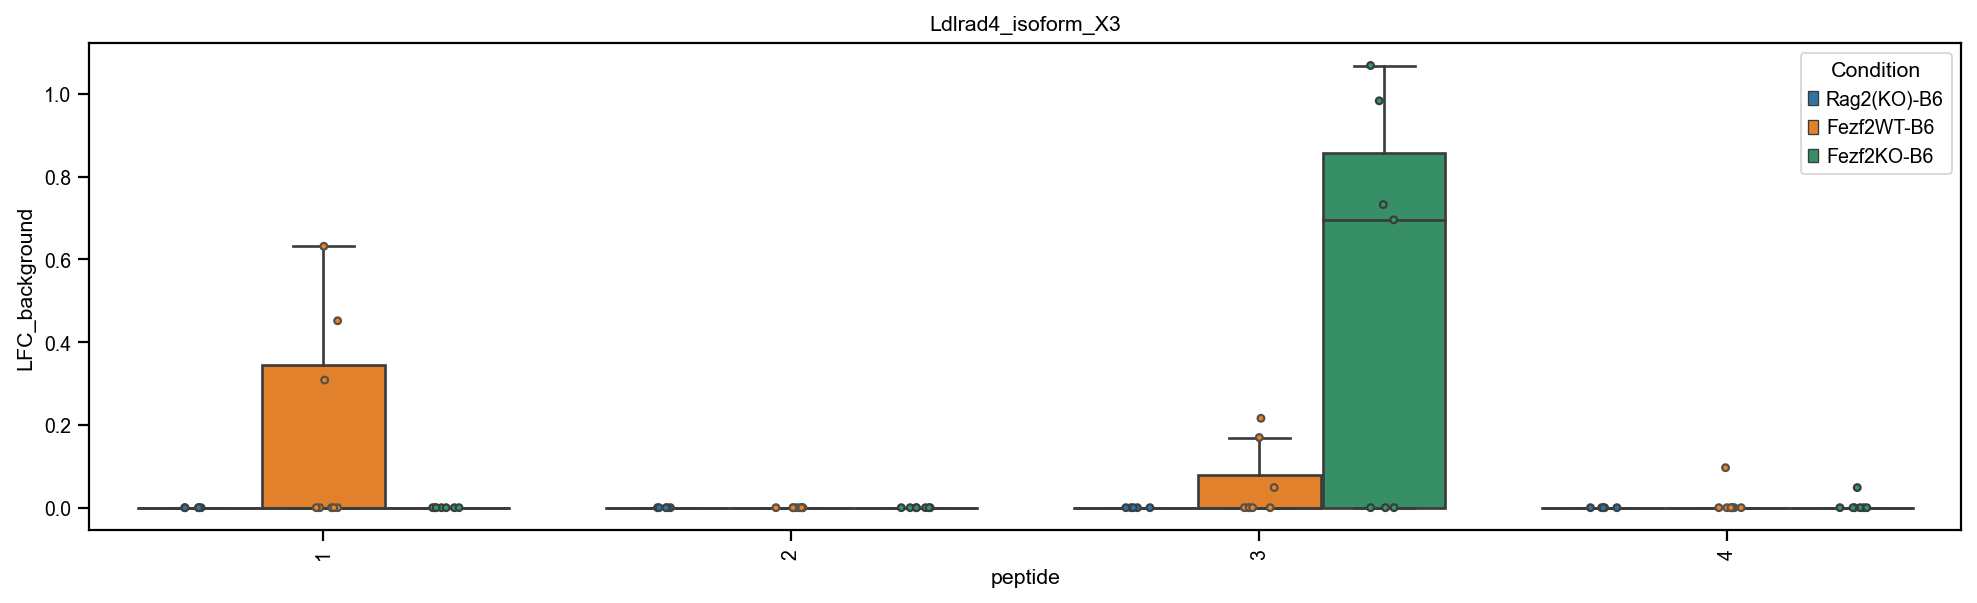

In [39]:
gene_level_box_plot(
    averaged_adata[averaged_adata.obs.Condition.isin(["Rag2(KO)-B6", "Fezf2WT-B6", "Fezf2KO-B6"])],
    "Condition",
    layer="LFC_background",
    gene="Ldlrad4",
    isoform_subset = "isoform_X3",
    figsize=(15,4),
    hue_order=["Rag2(KO)-B6", "Fezf2WT-B6", "Fezf2KO-B6"]
)

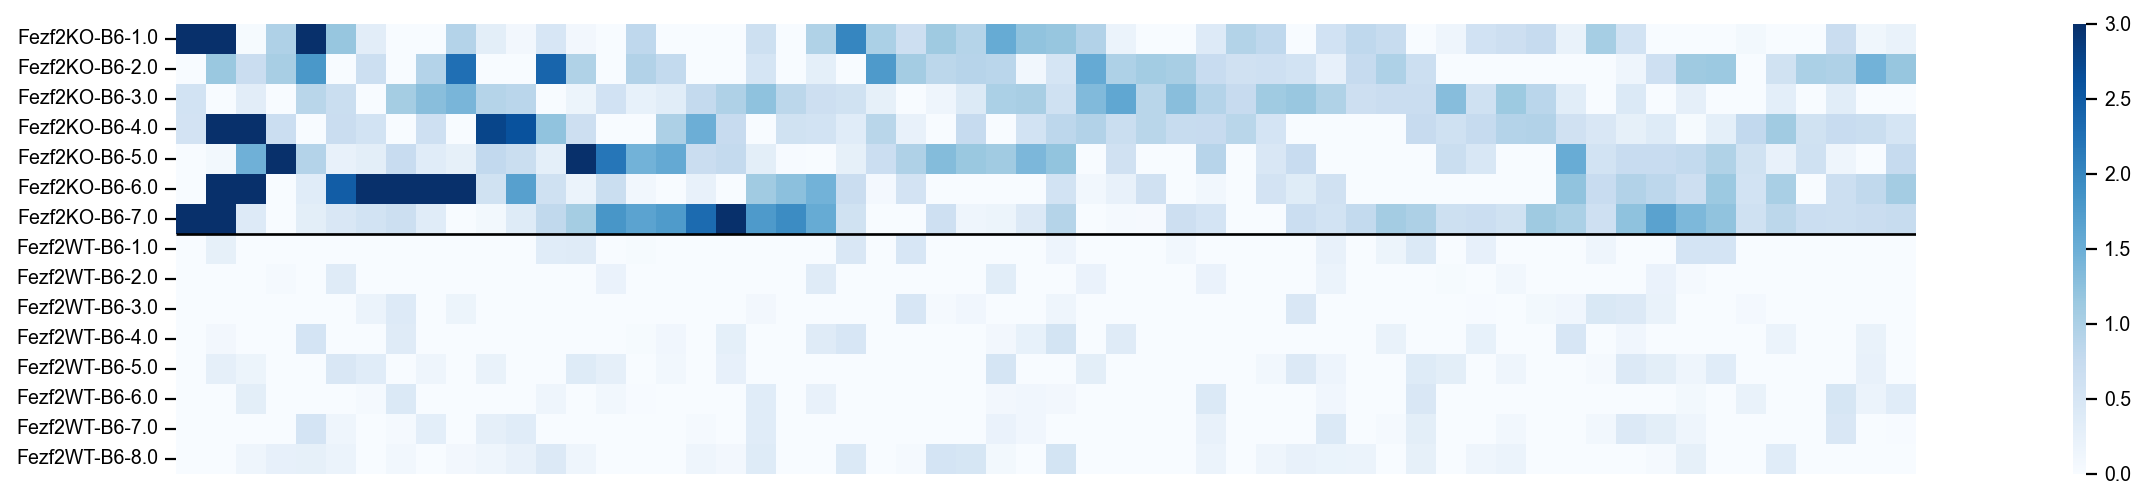

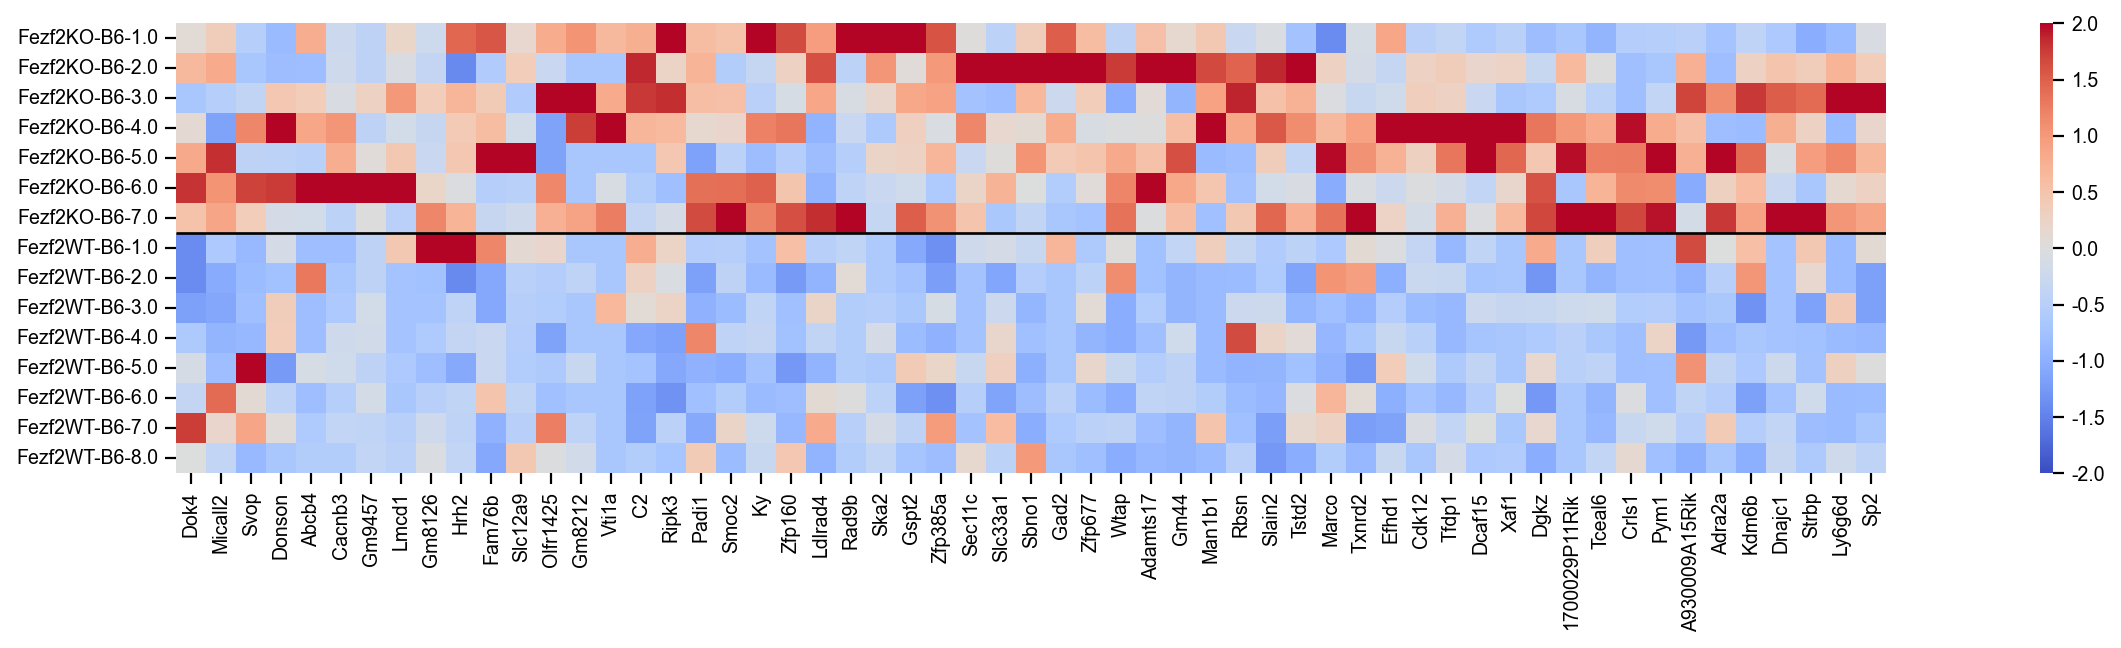

In [40]:
isoform = [i.split("isoform")[1] if "isoform" in i else "" for i in hits_Fezf2_KO_B6.index]
isoform = [f"isoform_{i.split('_')[1]}" if len(i) > 0 else '' for i in isoform]
hits_Fezf2_KO_B6["isoform"] = hits_Fezf2_KO_B6.gene + "_" + isoform

lfc_data_peptide = rna.tl.get_expression_matrix(averaged_adata, gene_data="LFC_background").copy()
lfc_data_peptide = lfc_data_peptide.loc[
    lfc_data_peptide.index.str.startswith("Fezf2") & lfc_data_peptide.index.str.contains("B6"),
    hits_Fezf2_KO_B6.index
]
LFC_heatmap(
    lfc_data_peptide,
    row_cluster=False,
    col_cluster=True,
    cmap="Blues",
    vmax=3,
    cell_width=15,
    cell_height=15,
    xticklabels=False,
    grouping=[7]
)

lfc_data_peptide = rna.tl.get_expression_matrix(
    averaged_adata[:, averaged_adata.var.gene.isin(hits_Fezf2_KO_B6.gene)],
    gene_data="LFC_background"
).copy()
lfc_data_peptide = lfc_data_peptide.loc[
    lfc_data_peptide.index.str.startswith("Fezf2") & lfc_data_peptide.index.str.contains("B6"),
    :
].T

lfc_data_peptide["gene"] = averaged_adata.var.gene
isoform = [i.split("isoform")[1] if "isoform" in i else "" for i in lfc_data_peptide.index]
isoform = [f"isoform_{i.split('_')[1]}" if len(i) > 0 else '' for i in isoform]
lfc_data_peptide["isoform"] = lfc_data_peptide.gene + "_" + isoform

lfc_data_peptide = lfc_data_peptide[lfc_data_peptide.isoform.isin(hits_Fezf2_KO_B6.isoform)]
del lfc_data_peptide["isoform"]

lfc_data_peptide = lfc_data_peptide.groupby("gene").sum().T

LFC_heatmap(
    lfc_data_peptide,
    row_cluster=False,
    col_cluster=True,
    cmap="coolwarm",
    vmax=2,
    vmin=-2,
    z_score=1,
    cell_width=15,
    cell_height=15,
    xticklabels=True,
    grouping=[7]
)

## Fezf2 KO CD1

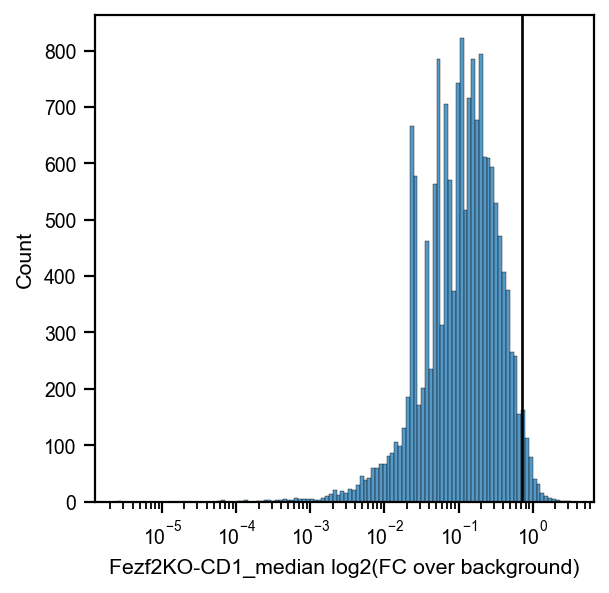

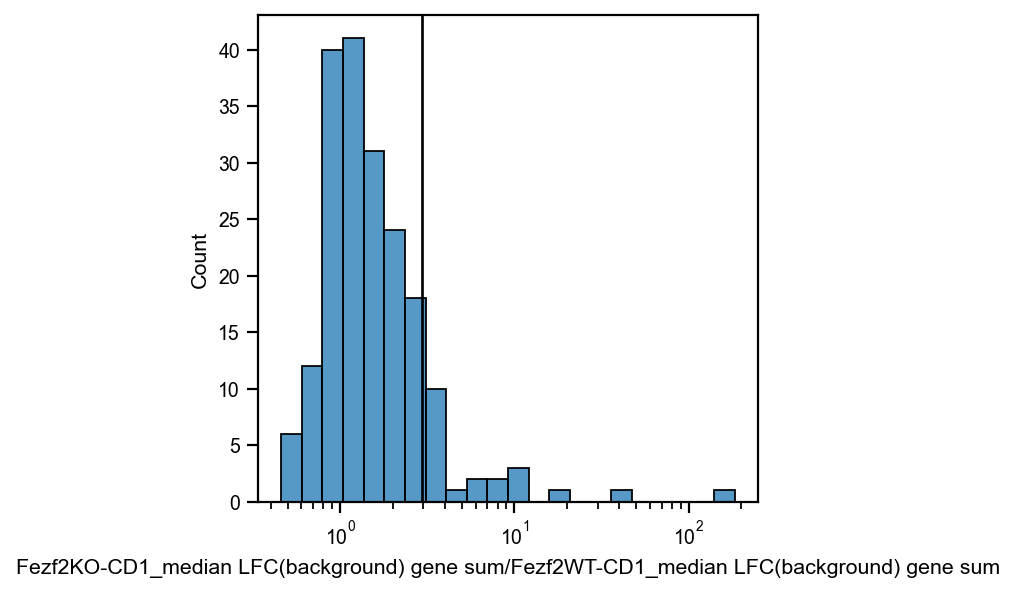

neg_control,Aire(KO)-B6,Aire(KO)-NOD,Aire(WT)-NOD,Background,Fezf2 Enr-CD1,Fezf2KO-B6,Fezf2KO-CD1,Fezf2WT-B6,Fezf2WT-CD1,GFAP-GFAP,...,Aire(KO)-NOD_mean,Aire(WT)-NOD_mean,Background_mean,Fezf2 Enr-CD1_mean,Fezf2KO-B6_mean,Fezf2KO-CD1_mean,Fezf2WT-B6_mean,Fezf2WT-CD1_mean,GFAP-GFAP_mean,gene_FC
peptide,,,,,,,,,,,,,,,,,,,,,
NP_067521.2_N-terminal_EF-hand_calcium-binding_protein_3_[Mus_musculus]_seq4,0,0,0,0,0,0,2,1,0,0,...,0.226091,0.230734,0.119013,0.000072,0.107427,1.042614,0.388067,0.000000,0.022580,3.401072
XP_006521539.1_PREDICTED:_protein_FAM118A_isoform_X1_[Mus_musculus]_seq8,0,1,2,0,1,0,1,0,0,0,...,0.409917,0.565628,0.188877,0.377946,0.559914,0.890922,0.171141,0.037844,0.051987,inf
XP_011239668.1_PREDICTED:_COP9_signalosome_complex_subunit_7a_isoform_X3_[Mus_musculus]_seq6,0,0,0,0,1,0,3,0,0,0,...,0.138409,0.000000,0.310268,0.941242,0.000358,2.242615,0.117904,0.000000,0.000000,inf
XP_006530181.1_PREDICTED:_2'-5'_oligoadenylate_synthetase_1C_isoform_X1_[Mus_musculus]_seq5,0,0,0,0,0,0,0,0,0,0,...,0.128127,0.188930,0.003932,0.174786,0.171139,0.664171,0.135141,0.000000,0.806100,inf
NP_001239503.1_solute_carrier_family_35_member_C2_isoform_1_[Mus_musculus]_seq7,0,0,0,0,2,0,1,0,0,0,...,0.181201,0.080370,0.000000,0.549296,0.495536,0.961484,0.092469,0.000000,0.713707,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NP_001299796.1_eukaryotic_translation_initiation_factor_4H_isoform_2_[Mus_musculus]_seq4,0,1,0,0,1,0,2,0,0,0,...,0.310561,0.146310,0.018055,0.475171,0.221637,1.515707,0.310381,0.000000,0.168076,inf
NP_775626.1_RNA_pseudouridylate_synthase_domain-containing_protein_2_[Mus_musculus]_seq9,0,0,0,0,0,0,1,0,0,0,...,0.116043,0.097110,0.115972,0.000000,0.009077,1.056252,0.000000,0.000000,0.215770,inf
XP_006509550.1_PREDICTED:_palmitoyltransferase_ZDHHC2_isoform_X2_[Mus_musculus]_seq4,0,0,0,0,0,0,2,0,0,0,...,0.128485,0.310152,0.000000,0.176866,0.066929,1.348787,0.088210,0.000000,0.466001,inf


In [41]:
genotype_stat = "Fezf2KO-CD1_median"
control_genotype_stat = "Fezf2WT-CD1_max"
hits_Fezf2_KO_CD1 = hits[hits[genotype_stat] > 0].copy() # Get rid of peptides with LFC over background <= 0

background_thresh = np.quantile(hits_Fezf2_KO_CD1[genotype_stat], 0.975)
sns.histplot(hits_Fezf2_KO_CD1[genotype_stat], log_scale=True)
plt.axvline(x=background_thresh, c="black")
plt.xlabel(f"{genotype_stat} log2(FC over background)")
plt.show()

hits_Fezf2_KO_CD1 = hits_Fezf2_KO_CD1[hits_Fezf2_KO_CD1[genotype_stat] >= background_thresh].copy()
hits_Fezf2_KO_CD1 = hits_Fezf2_KO_CD1[hits_Fezf2_KO_CD1[control_genotype_stat] < background_thresh]
hits_Fezf2_KO_CD1["gene_FC"] = list(gene_hits.loc[hits_Fezf2_KO_CD1.gene, "Fezf2KO-CD1_median"]/gene_hits.loc[hits_Fezf2_KO_CD1.gene, "Fezf2WT-CD1_median"])

hits_Fezf2_KO_CD1 = hits_Fezf2_KO_CD1[hits_Fezf2_KO_CD1["gene_FC"] > 0] # Get rid of peptides with gene-wise FC over wild type = 0 

unique_genes = hits_Fezf2_KO_CD1.drop_duplicates(subset="gene")
gene_FC_thresh = np.quantile(unique_genes["gene_FC"], 0.7)
sns.histplot(unique_genes["gene_FC"], log_scale=True)
plt.axvline(x=gene_FC_thresh, c="black")
plt.xlabel("Fezf2KO-CD1_median LFC(background) gene sum/Fezf2WT-CD1_median LFC(background) gene sum")
plt.show()

hits_Fezf2_KO_CD1 = hits_Fezf2_KO_CD1[hits_Fezf2_KO_CD1.gene_FC >= gene_FC_thresh]
hits_Fezf2_KO_CD1

In [42]:
hits_Fezf2_KO_CD1 = hits_Fezf2_KO_CD1.sort_values(by="Fezf2KO-CD1_median")
hits_Fezf2_KO_CD1.gene

peptide
XP_006506003.1_PREDICTED:_protein_FAM221A_isoform_X3_[Mus_musculus]_seq5                                    Fam221a
XP_011240596.1_PREDICTED:_Kruppel-like_zinc_finger_protein_isoform_X2_[Mus_musculus]_seq2                    Zfp868
NP_705729.1_UPF0258_protein_KIAA1024_[Mus_musculus]_seq19                                                  AF529169
NP_038808.2_neuronal_PAS_domain-containing_protein_3_[Mus_musculus]_seq4                                      Npas3
XP_017175142.1_PREDICTED:_aldehyde_oxidase_2_isoform_X1_[Mus_musculus]_seq17                                   Aox2
                                                                                                          ...      
XP_006527277.1_PREDICTED:_inactive_heparanase-2_isoform_X1_[Mus_musculus]_seq4                                Hpse2
XP_017177165.1_PREDICTED:_BTB/POZ_domain-containing_protein_KCTD18_isoform_X2_[Mus_musculus]_seq4            Kctd18
NP_780738.1_leukocyte_receptor_cluster_member_9_[Mus_musculus]_s

In [43]:
hits_Fezf2_KO_CD1.sort_values(by="gene_FC").gene

peptide
NP_033216.2_vacuolar_protein_sorting-associated_protein_4B_[Mus_musculus]_seq9                              Vps4b
NP_848825.2_serine/threonine-protein_kinase_SIK2_[Mus_musculus]_seq21                                        Sik2
XP_011249076.1_PREDICTED:_protein_unc-45_homolog_A_isoform_X1_[Mus_musculus]_seq8                          Unc45a
NP_766075.2_proline-rich_transmembrane_protein_3_isoform_b_precursor_[Mus_musculus]_seq5                    Prrt3
XP_006515672.1_PREDICTED:_endoribonuclease_Dicer_isoform_X1_[Mus_musculus]_seq15                           Dicer1
                                                                                                            ...  
XP_006497186.1_PREDICTED:_serine/threonine-protein_kinase_Nek2_isoform_X1_[Mus_musculus]_seq7                Nek2
NP_766466.3_tetratricopeptide_repeat_protein_34_[Mus_musculus]_seq12                                        Ttc34
XP_011238805.1_PREDICTED:_thyroid_hormone_receptor-associated_protein_3_isoform_

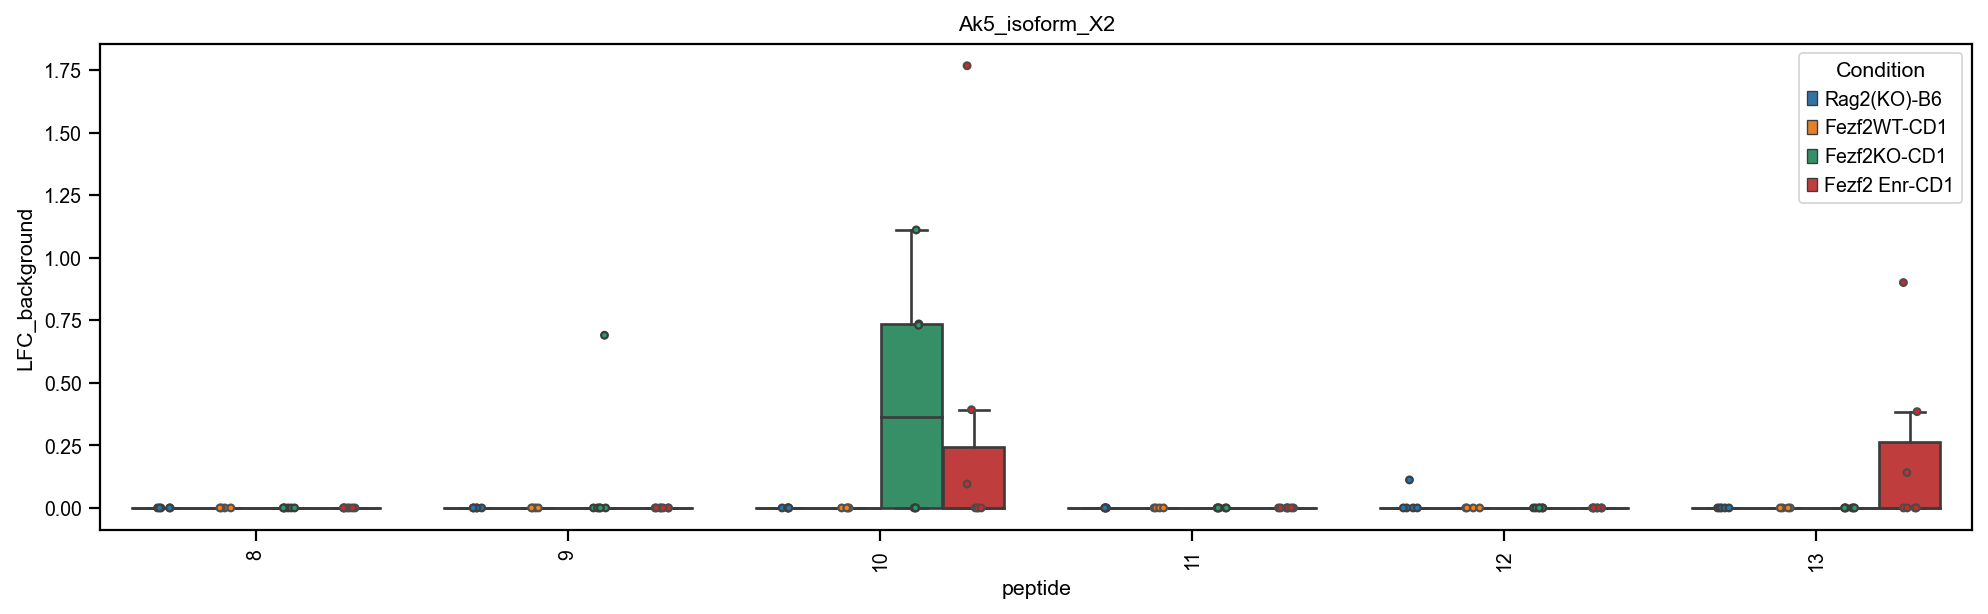

In [45]:
gene_level_box_plot(
    averaged_adata,
    "Condition",
    layer="LFC_background",
    gene="Ak5",
    isoform_subset = "isoform_X2",
    figsize=(15,4),
    hue_order=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"]
)

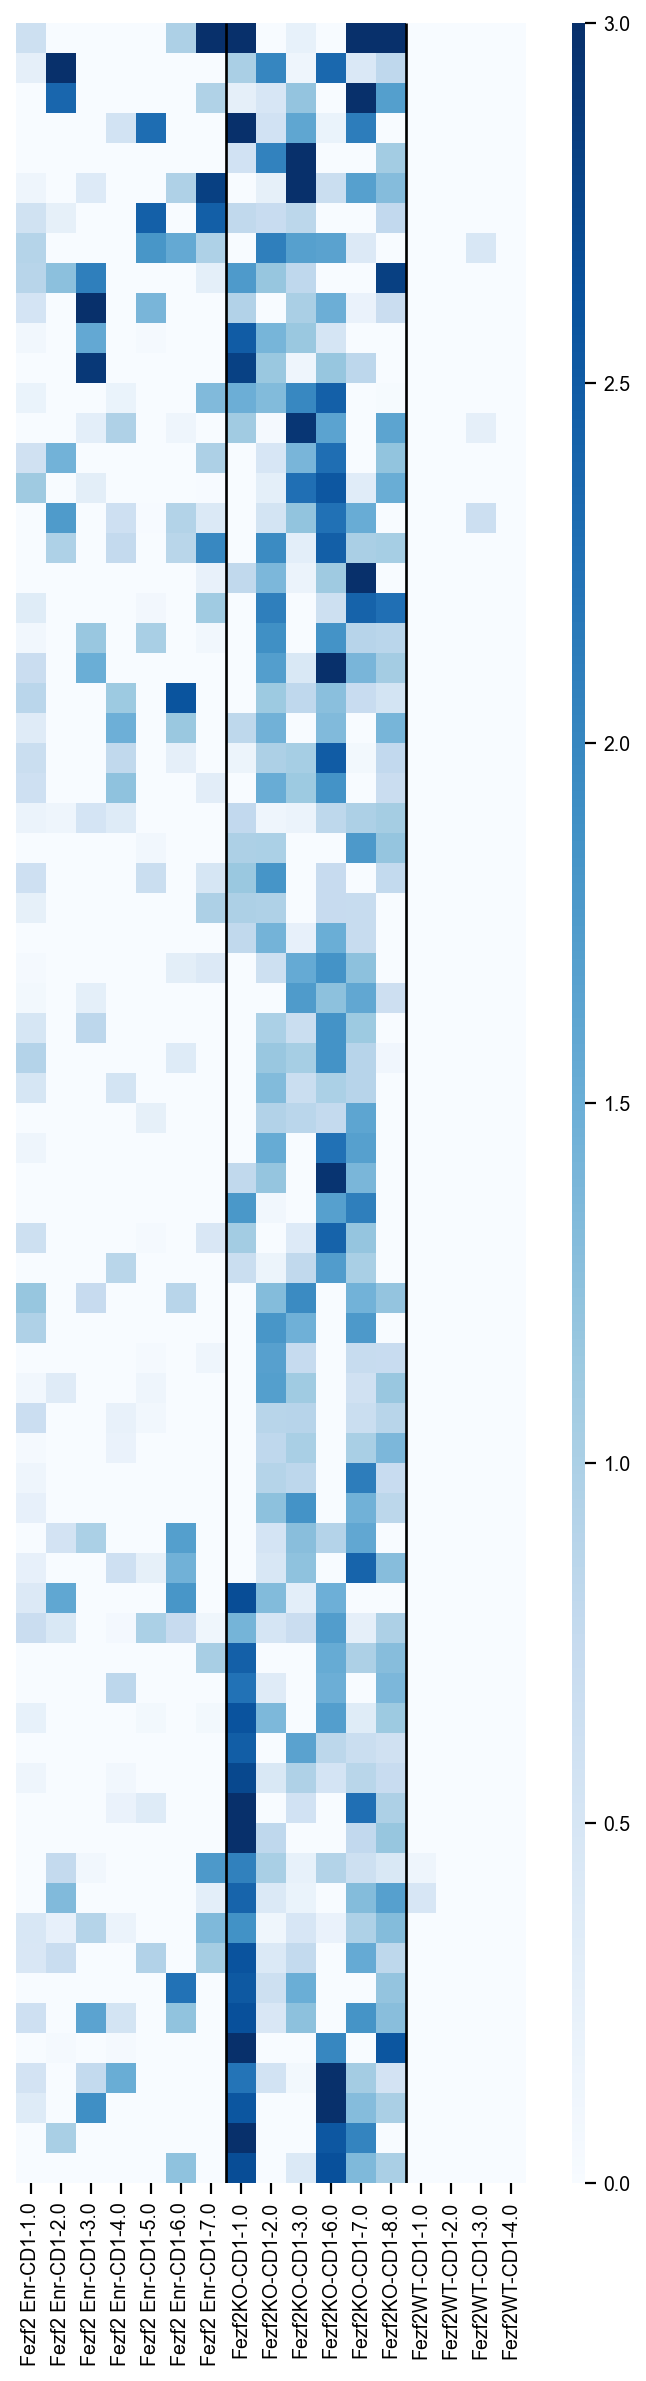

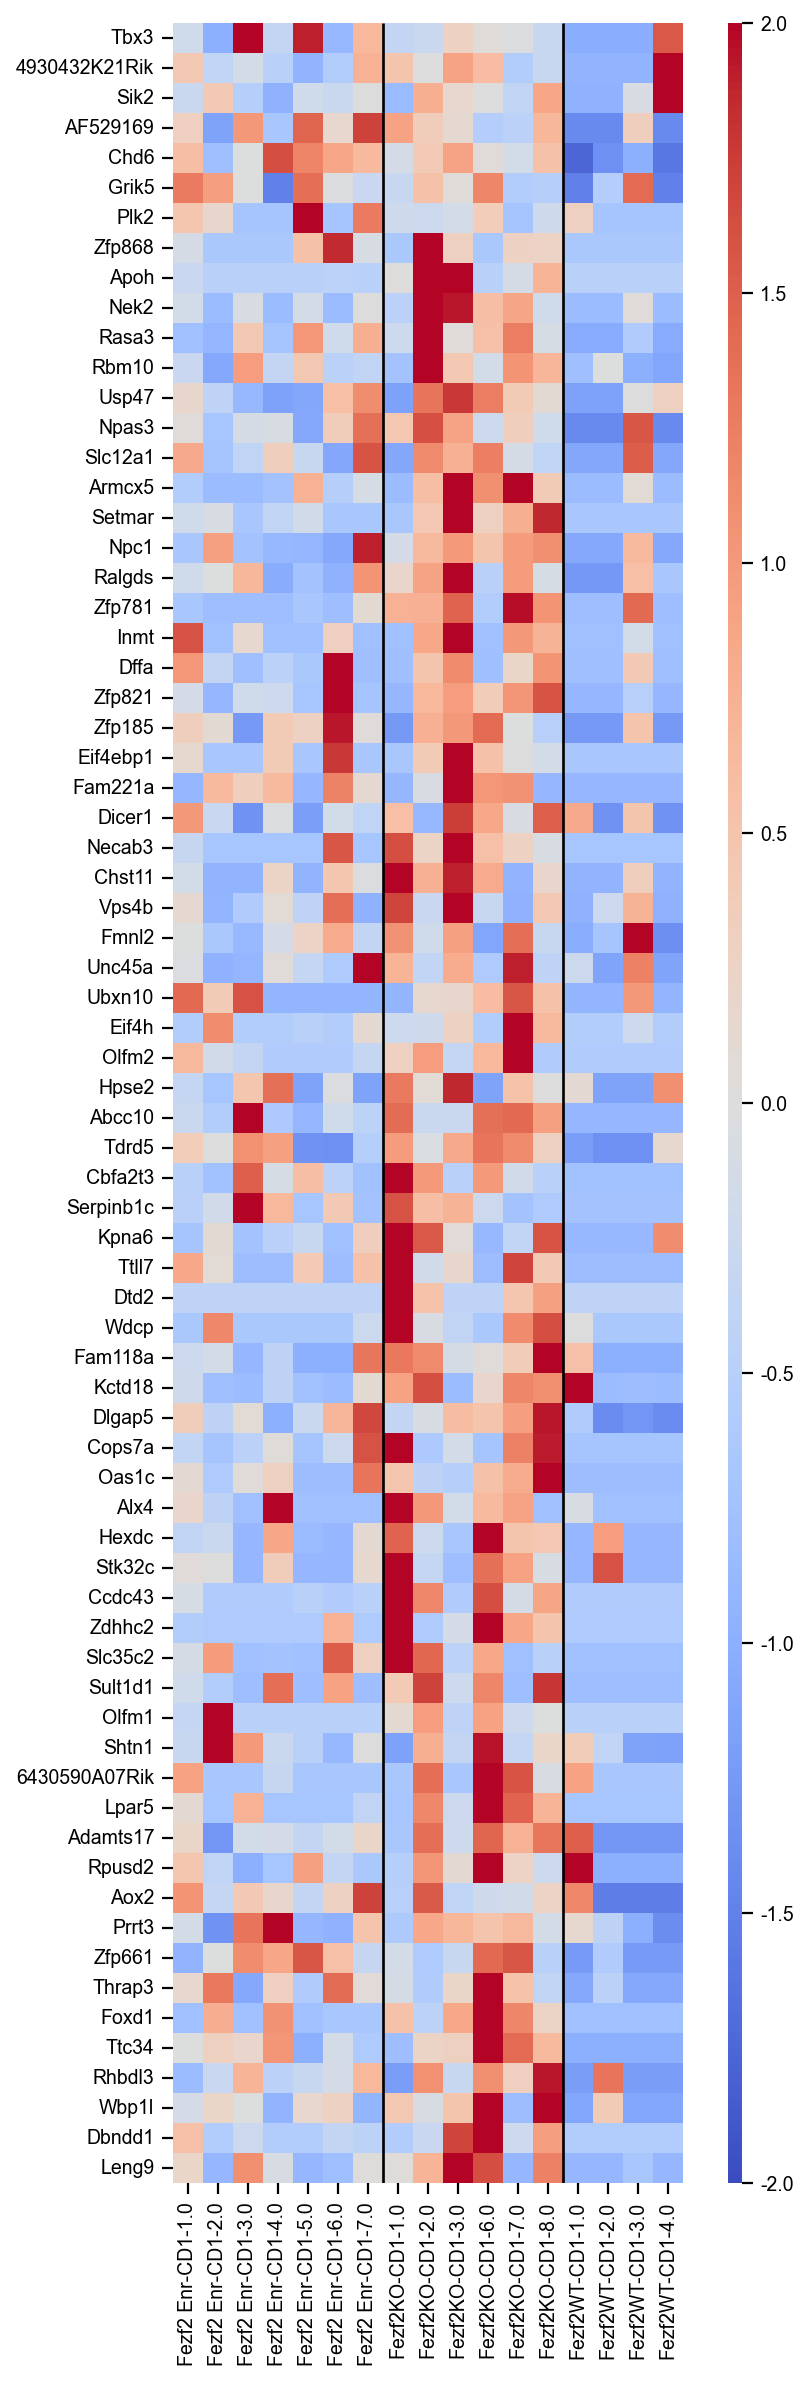

In [77]:
isoform = [i.split("isoform")[1] if "isoform" in i else "" for i in hits_Fezf2_KO_CD1.index]
isoform = [f"isoform_{i.split('_')[1]}" if len(i) > 0 else '' for i in isoform]
hits_Fezf2_KO_CD1["isoform"] = hits_Fezf2_KO_CD1.gene + "_" + isoform

lfc_data_peptide = rna.tl.get_expression_matrix(averaged_adata, gene_data="LFC_background").copy()
lfc_data_peptide = lfc_data_peptide.loc[
    lfc_data_peptide.index.str.startswith("Fezf2") & lfc_data_peptide.index.str.contains("CD1"),
    hits_Fezf2_KO_CD1.index
]
LFC_heatmap(
    lfc_data_peptide.T,
    col_cluster=False,
    row_cluster=True,
    cmap="Blues",
    vmax=3,
    cell_width=15,
    cell_height=15,
    yticklabels=False,
    grouping=[7,13],
    grouping_axis=1,
    save_path="../analysis/paper_figures/S7/S7E_KO_PhIP_seq_peptide_hits.pdf"
)

lfc_data_peptide = rna.tl.get_expression_matrix(
    averaged_adata[:, averaged_adata.var.gene.isin(hits_Fezf2_KO_CD1.gene)],
    gene_data="LFC_background"
).copy()
lfc_data_peptide = lfc_data_peptide.loc[
    lfc_data_peptide.index.str.startswith("Fezf2") & lfc_data_peptide.index.str.contains("CD1"),
    :
].T

lfc_data_peptide["gene"] = averaged_adata.var.gene
isoform = [i.split("isoform")[1] if "isoform" in i else "" for i in lfc_data_peptide.index]
isoform = [f"isoform_{i.split('_')[1]}" if len(i) > 0 else '' for i in isoform]
lfc_data_peptide["isoform"] = lfc_data_peptide.gene + "_" + isoform

lfc_data_peptide = lfc_data_peptide[lfc_data_peptide.isoform.isin(hits_Fezf2_KO_CD1.isoform)]
del lfc_data_peptide["isoform"]

lfc_data_peptide = lfc_data_peptide.groupby("gene").sum().T

LFC_heatmap(
    lfc_data_peptide.T,
    col_cluster=False,
    row_cluster=True,
    cmap="coolwarm",
    vmax=2,
    vmin=-2,
    z_score=0,
    cell_width=15,
    cell_height=15,
    yticklabels=True,
    grouping=[7,13],
    grouping_axis=1,
    save_path="../analysis/paper_figures/S7/S7F_KO_PhIP_seq_gene_hits.pdf"
)

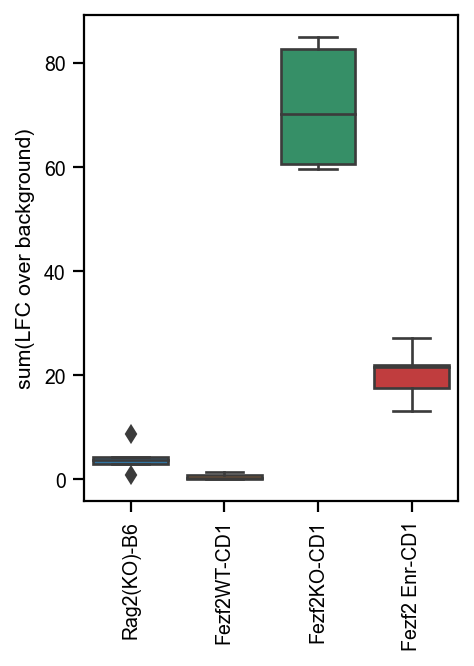

In [65]:
peptide_sums = plot_FC_sum(
    averaged_adata[:,averaged_adata.var.index.isin(hits_Fezf2_KO_CD1.index)],
    "LFC_background",
    obs_group_key="Condition",
    obs_group_values=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    order=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    save_path=None
)

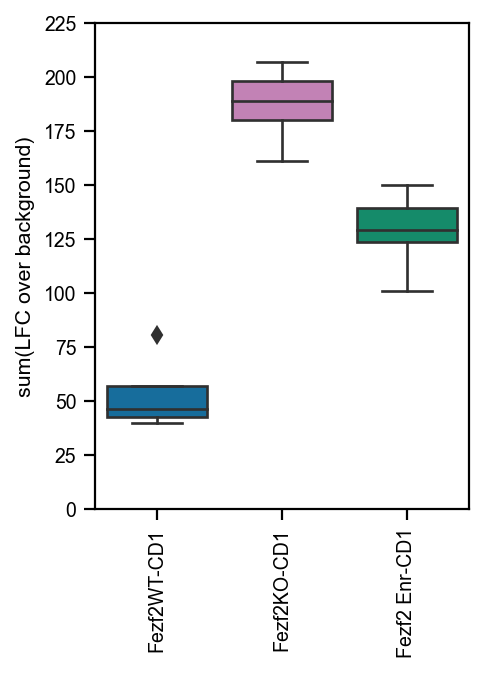

In [94]:
gene_sums = plot_FC_sum(
    averaged_adata[:,averaged_adata.var.gene.isin(hits_Fezf2_KO_CD1.gene)],
    "LFC_background",
    obs_group_key="Condition",
    obs_group_values=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    order=["Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    save_path="../analysis/paper_figures/5/5F_EnR_PhIP_seq.pdf",
    ylim=(0,225),
    palette=[cmap[0]] + [cmap[4]] + [cmap[2]]
)

In [68]:
ttest_ind(gene_sums[gene_sums.Condition == "Fezf2 Enr-CD1"][0], gene_sums[gene_sums.Condition == "Fezf2KO-CD1"][0])

TtestResult(statistic=-6.22924234049839, pvalue=6.445340193794468e-05, df=11.0)

In [69]:
ttest_ind(gene_sums[gene_sums.Condition == "Fezf2WT-CD1"][0], gene_sums[gene_sums.Condition == "Fezf2KO-CD1"][0])

TtestResult(statistic=-11.94466511453092, pvalue=2.2207069122570112e-06, df=8.0)

## Fezf2 EnR CD1

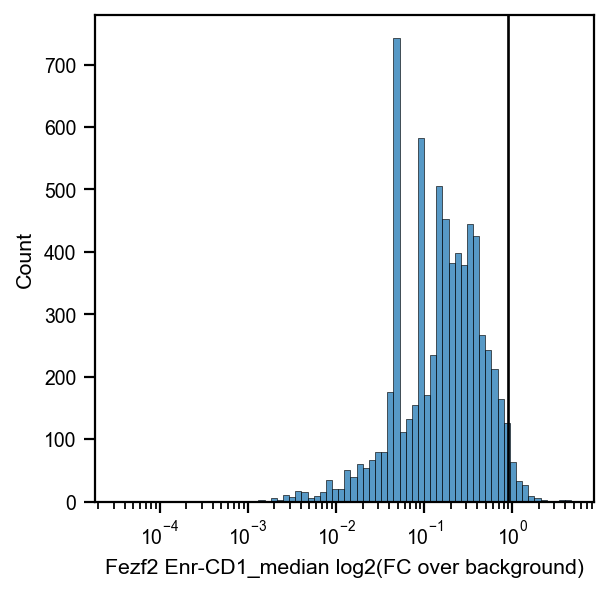

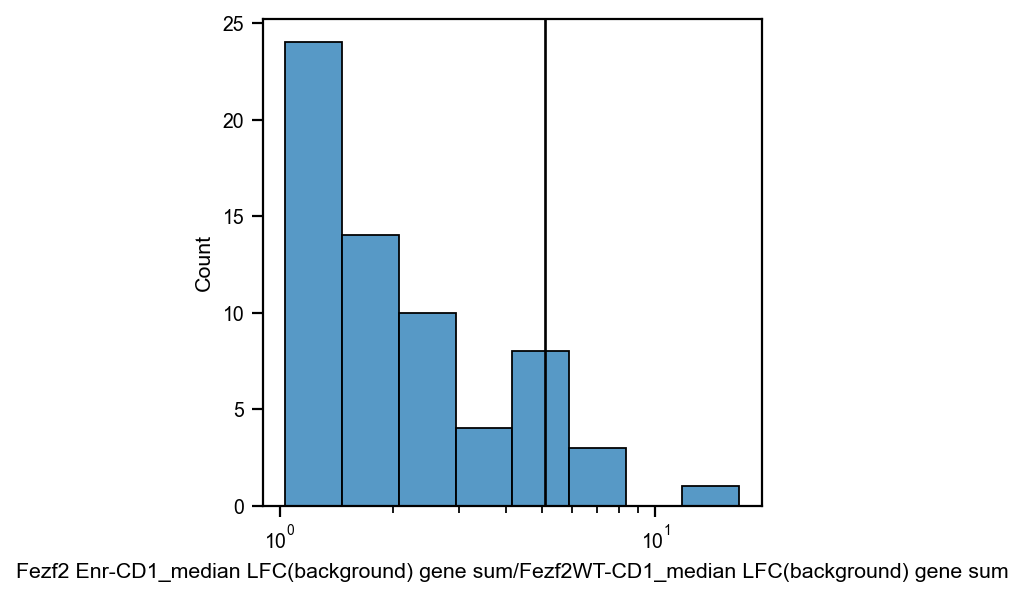

neg_control,Aire(KO)-B6,Aire(KO)-NOD,Aire(WT)-NOD,Background,Fezf2 Enr-CD1,Fezf2KO-B6,Fezf2KO-CD1,Fezf2WT-B6,Fezf2WT-CD1,GFAP-GFAP,...,Aire(KO)-NOD_mean,Aire(WT)-NOD_mean,Background_mean,Fezf2 Enr-CD1_mean,Fezf2KO-B6_mean,Fezf2KO-CD1_mean,Fezf2WT-B6_mean,Fezf2WT-CD1_mean,GFAP-GFAP_mean,gene_FC
peptide,,,,,,,,,,,,,,,,,,,,,
NP_114387.1_centrosomal_protein_of_41_kDa_[Mus_musculus]_seq6,0,1,0,0,2,0,1,0,0,0,...,0.380638,0.342613,0.039615,0.991798,0.761803,0.419004,0.244424,0.000000,0.109168,inf
XP_011238090.1_PREDICTED:_zinc_finger_protein_2_isoform_X2_[Mus_musculus]_seq7,0,0,1,0,1,0,0,0,0,0,...,0.375960,0.324172,0.075617,1.468067,0.302608,0.154394,0.492942,0.000000,0.421802,inf
NP_001272418.1_nucleosome_assembly_protein_1-like_4_isoform_a_[Mus_musculus]_seq8,1,0,0,0,2,0,0,0,0,0,...,0.329444,0.334804,0.073289,0.946525,0.294725,0.226356,0.235227,0.000000,0.374758,inf
XP_006510337.1_PREDICTED:_zinc_finger_protein_317_isoform_X1_[Mus_musculus]_seq3,0,0,0,0,0,0,1,0,0,0,...,0.301404,0.545773,0.057643,0.896314,0.706286,0.574966,0.352797,0.000000,0.401374,inf
XP_011247797.1_PREDICTED:_ADP-ribosylation_factor-like_protein_9_isoform_X3_[Mus_musculus]_seq2,0,1,0,0,0,1,0,0,0,0,...,0.649948,0.483201,0.000000,0.645036,0.702348,0.253444,0.357777,0.000000,0.622739,inf
XP_006528757.1_PREDICTED:_rho_GTPase-activating_protein_6_isoform_X1_[Mus_musculus]_seq22,0,4,3,0,1,0,1,1,0,0,...,0.757110,0.740805,0.051738,0.996709,0.293981,0.419878,0.651083,0.000000,1.059331,5.193685
XP_017177353.1_PREDICTED:_uncharacterized_protein_LOC108169152_isoform_X1_[Mus_musculus]_seq5,1,1,0,0,4,2,0,1,0,0,...,0.219927,0.064589,0.149839,1.845421,2.228790,0.363377,0.840906,0.142191,0.350519,6.539493
XP_006540423.1_PREDICTED:_carcinoembryonic_antigen-related_cell_adhesion_molecule_20_isoform_X1_[Mus_musculus]_seq4,0,0,0,0,0,0,0,0,0,0,...,0.186135,0.063894,0.000000,0.636403,0.056339,0.000000,0.096582,0.000000,0.118348,inf
XP_006532992.1_PREDICTED:_WSC_domain-containing_protein_1_isoform_X1_[Mus_musculus]_seq8,0,1,0,0,2,1,0,1,0,0,...,0.287681,0.304887,0.116687,1.113980,0.568424,0.024018,0.858582,0.000000,0.000000,inf


In [51]:
genotype_stat = "Fezf2 Enr-CD1_median"
control_genotype_stat = "Fezf2WT-CD1_max"
hits_Fezf2_EnR_CD1 = hits[hits[genotype_stat] > 0].copy() # Get rid of peptides with LFC over background <= 0

background_thresh = np.quantile(hits_Fezf2_EnR_CD1[genotype_stat], 0.975)
sns.histplot(hits_Fezf2_EnR_CD1[genotype_stat], log_scale=True)
plt.axvline(x=background_thresh, c="black")
plt.xlabel(f"{genotype_stat} log2(FC over background)")
plt.show()

hits_Fezf2_EnR_CD1 = hits_Fezf2_EnR_CD1[hits_Fezf2_EnR_CD1[genotype_stat] >= background_thresh].copy()
hits_Fezf2_EnR_CD1 = hits_Fezf2_EnR_CD1[hits_Fezf2_EnR_CD1[control_genotype_stat] < background_thresh]
hits_Fezf2_EnR_CD1["gene_FC"] = list(gene_hits.loc[hits_Fezf2_EnR_CD1.gene, "Fezf2 Enr-CD1_median"]/gene_hits.loc[hits_Fezf2_EnR_CD1.gene, "Fezf2WT-CD1_median"])

hits_Fezf2_EnR_CD1 = hits_Fezf2_EnR_CD1[hits_Fezf2_EnR_CD1["gene_FC"] > 1] # Get rid of peptides with gene-wise FC over wild type <= 1

unique_genes = hits_Fezf2_EnR_CD1.drop_duplicates(subset="gene")
gene_FC_thresh = np.quantile(unique_genes["gene_FC"], 0.7)
sns.histplot(unique_genes["gene_FC"], log_scale=True)
plt.axvline(x=gene_FC_thresh, c="black")
plt.xlabel("Fezf2 Enr-CD1_median LFC(background) gene sum/Fezf2WT-CD1_median LFC(background) gene sum")
plt.show()

hits_Fezf2_EnR_CD1 = hits_Fezf2_EnR_CD1[hits_Fezf2_EnR_CD1.gene_FC >= gene_FC_thresh]
hits_Fezf2_EnR_CD1

In [52]:
hits_Fezf2_EnR_CD1 = hits_Fezf2_EnR_CD1.sort_values(by="Fezf2 Enr-CD1_median", ascending=False)
hits_Fezf2_EnR_CD1.gene

peptide
NP_084484.2_probable_tRNA_(uracil-O(2)-)-methyltransferase_[Mus_musculus]_seq2                                                Trmt44
XP_017177353.1_PREDICTED:_uncharacterized_protein_LOC108169152_isoform_X1_[Mus_musculus]_seq5                                Gm46965
NP_062740.1_prostaglandin_E_synthase_3_[Mus_musculus]_seq3                                                                    Ptges3
NP_001094980.1_sushi_domain-containing_protein_5_precursor_[Mus_musculus]_seq5                                                 Susd5
XP_006528757.1_PREDICTED:_rho_GTPase-activating_protein_6_isoform_X1_[Mus_musculus]_seq22                                    Arhgap6
XP_017168538.1_PREDICTED:_cell_surface_glycoprotein_1_[Mus_musculus]_seq8                                              9530057J20Rik
NP_080397.1_BAG_family_molecular_chaperone_regulator_4_[Mus_musculus]_seq5                                                      Bag4
NP_001272418.1_nucleosome_assembly_protein_1-like_4_isoform_a

In [53]:
hits_Fezf2_EnR_CD1.gene_FC

peptide
NP_084484.2_probable_tRNA_(uracil-O(2)-)-methyltransferase_[Mus_musculus]_seq2                                               inf
XP_017177353.1_PREDICTED:_uncharacterized_protein_LOC108169152_isoform_X1_[Mus_musculus]_seq5                           6.539493
NP_062740.1_prostaglandin_E_synthase_3_[Mus_musculus]_seq3                                                                   inf
NP_001094980.1_sushi_domain-containing_protein_5_precursor_[Mus_musculus]_seq5                                          8.001450
XP_006528757.1_PREDICTED:_rho_GTPase-activating_protein_6_isoform_X1_[Mus_musculus]_seq22                               5.193685
XP_017168538.1_PREDICTED:_cell_surface_glycoprotein_1_[Mus_musculus]_seq8                                                    inf
NP_080397.1_BAG_family_molecular_chaperone_regulator_4_[Mus_musculus]_seq5                                              6.273441
NP_001272418.1_nucleosome_assembly_protein_1-like_4_isoform_a_[Mus_musculus]_seq8        

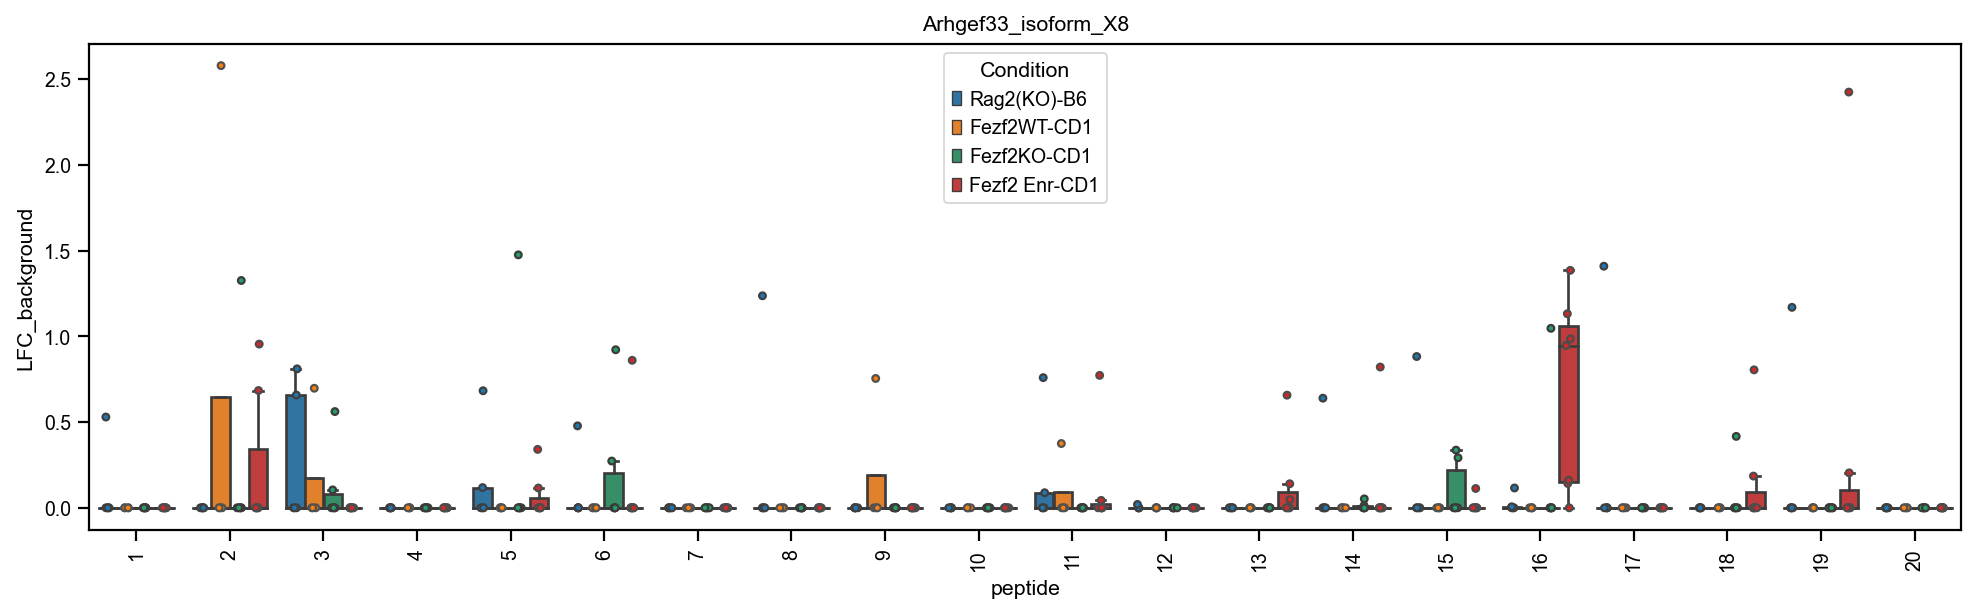

In [54]:
gene_level_box_plot(
    averaged_adata,
    "Condition",
    layer="LFC_background",
    gene="Arhgef33",
    isoform_subset = "isoform_X8",
    figsize=(15,4),
    hue_order=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"]
)

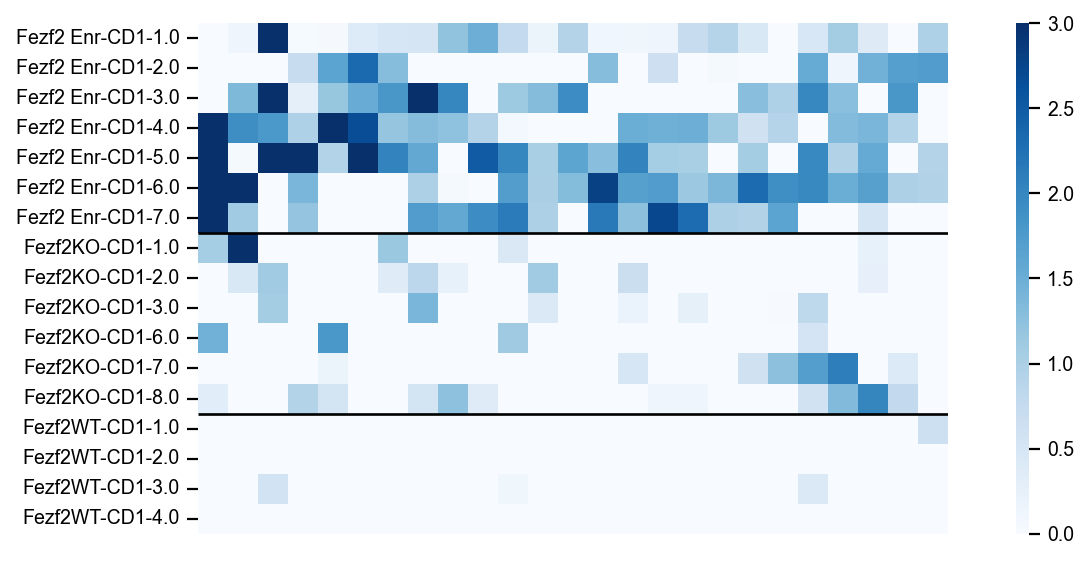

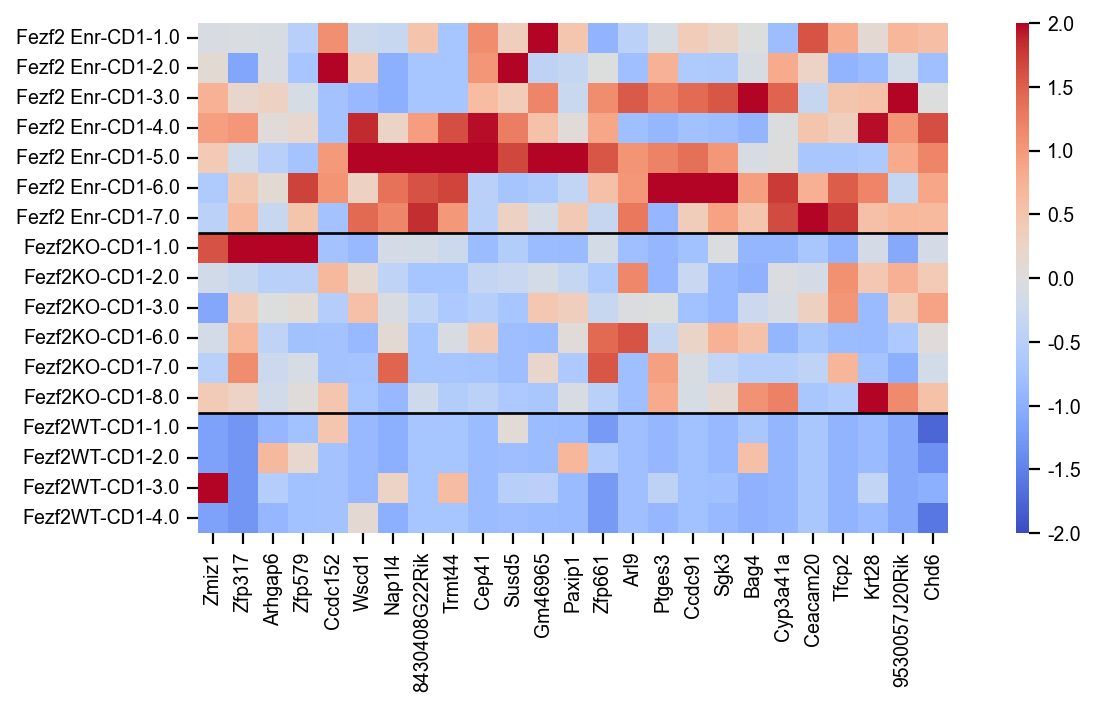

In [70]:
isoform = [i.split("isoform")[1] if "isoform" in i else "" for i in hits_Fezf2_EnR_CD1.index]
isoform = [f"isoform_{i.split('_')[1]}" if len(i) > 0 else '' for i in isoform]
hits_Fezf2_EnR_CD1["isoform"] = hits_Fezf2_EnR_CD1.gene + "_" + isoform

lfc_data_peptide = rna.tl.get_expression_matrix(averaged_adata, gene_data="LFC_background").copy()
lfc_data_peptide = lfc_data_peptide.loc[
    lfc_data_peptide.index.str.startswith("Fezf2") & lfc_data_peptide.index.str.contains("CD1"),
    hits_Fezf2_EnR_CD1.index
]
LFC_heatmap(
    lfc_data_peptide,
    row_cluster=False,
    col_cluster=True,
    cmap="Blues",
    vmax=3,
    cell_width=15,
    cell_height=15,
    xticklabels=False,
    grouping=[7,13]
)

lfc_data_peptide = rna.tl.get_expression_matrix(
    averaged_adata[:, averaged_adata.var.gene.isin(hits_Fezf2_EnR_CD1.gene)],
    gene_data="LFC_background"
).copy()
lfc_data_peptide = lfc_data_peptide.loc[
    lfc_data_peptide.index.str.startswith("Fezf2") & lfc_data_peptide.index.str.contains("CD1"),
    :
].T

lfc_data_peptide["gene"] = averaged_adata.var.gene
isoform = [i.split("isoform")[1] if "isoform" in i else "" for i in lfc_data_peptide.index]
isoform = [f"isoform_{i.split('_')[1]}" if len(i) > 0 else '' for i in isoform]
lfc_data_peptide["isoform"] = lfc_data_peptide.gene + "_" + isoform

lfc_data_peptide = lfc_data_peptide[lfc_data_peptide.isoform.isin(hits_Fezf2_EnR_CD1.isoform)]
del lfc_data_peptide["isoform"]

lfc_data_peptide = lfc_data_peptide.groupby("gene").sum().T

LFC_heatmap(
    lfc_data_peptide,
    row_cluster=False,
    col_cluster=True,
    cmap="coolwarm",
    vmax=2,
    vmin=-2,
    z_score=1,
    cell_width=15,
    cell_height=15,
    xticklabels=True,
    grouping=[7,13]
)

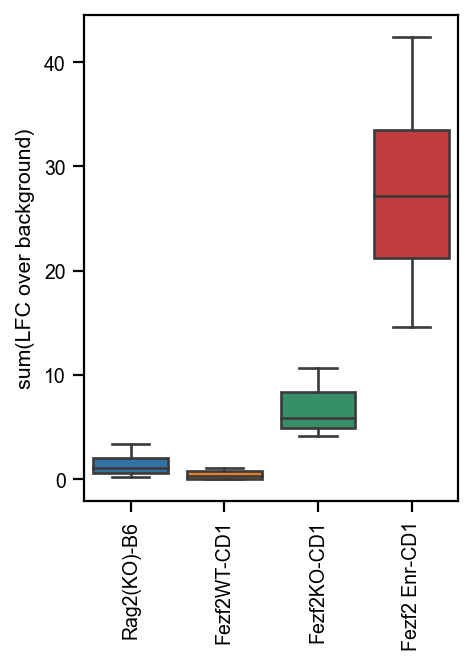

In [71]:
e = plot_FC_sum(
    averaged_adata[:,averaged_adata.var.index.isin(hits_Fezf2_EnR_CD1.index)],
    "LFC_background",
    obs_group_key="Condition",
    obs_group_values=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    order=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    save_path=None
)

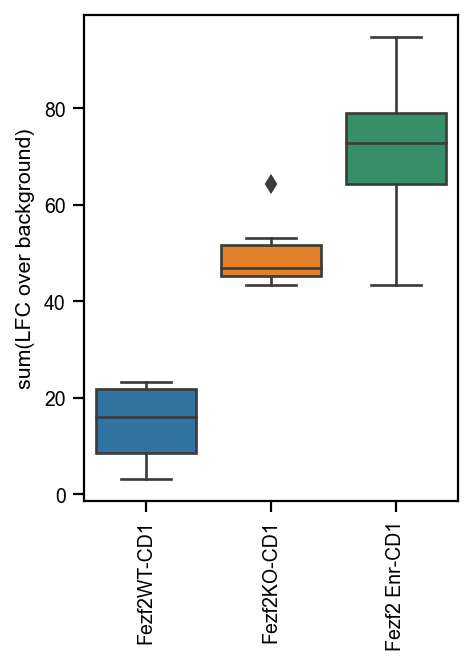

In [90]:
e = plot_FC_sum(
    averaged_adata[:,averaged_adata.var.gene.isin(hits_Fezf2_EnR_CD1.gene)],
    "LFC_background",
    obs_group_key="Condition",
    obs_group_values=["Rag2(KO)-B6", "Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    order=["Fezf2WT-CD1", "Fezf2KO-CD1", "Fezf2 Enr-CD1"],
    save_path=None,
)

In [73]:
ttest_ind(e[e.Condition == "Fezf2 Enr-CD1"][0], e[e.Condition == "Fezf2KO-CD1"][0])

TtestResult(statistic=2.920296252810517, pvalue=0.013930101341537007, df=11.0)

In [74]:
ttest_ind(e[e.Condition == "Fezf2WT-CD1"][0], e[e.Condition == "Fezf2KO-CD1"][0])

TtestResult(statistic=-6.4478275722647655, pvalue=0.000198767946050575, df=8.0)

# Cell x gene tissue expression

In [58]:
genes = pd.read_csv(f"{processedDataPath}/cell_x_gene_atlas/expression/keep_genes.csv").feature_name
tissue_general_expression = np.load(f"{processedDataPath}/cell_x_gene_atlas/expression/cell_x_gene_atlas_tissue_general_expression.npy")
index = pd.read_csv(f"{processedDataPath}/cell_x_gene_atlas/expression/tissue_general_index.csv").tissue_general
tissue_general_expression = pd.DataFrame(tissue_general_expression, index=index, columns=genes)

In [59]:
genes = hits_Fezf2_KO_CD1[hits_Fezf2_KO_CD1.gene.isin(tissue_general_expression.columns)].gene.tolist()
top_tissues = pd.DataFrame(tissue_general_expression[genes].idxmax())

In [60]:
top_tissues[top_tissues[0] == "brain"].index.tolist()

['Zfp868',
 'Npas3',
 'Aox2',
 'Prrt3',
 'Grik5',
 'Necab3',
 'Dffa',
 'Ttll7',
 'Zfp661',
 'Adamts17',
 'Sik2',
 'Kpna6',
 'Zfp821',
 'Wdcp',
 'Chd6',
 'Setmar',
 'Olfm1',
 'Dbndd1',
 'Olfm2',
 'Shtn1',
 'Stk32c',
 'Rhbdl3',
 'Fmnl2',
 'Abcc10',
 'Zdhhc2']

# Save hits

In [80]:
hits_Fezf2_KO_CD1.to_csv("../analysis/PhIP-seq_Fezf2_tKO_hits.csv")